In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

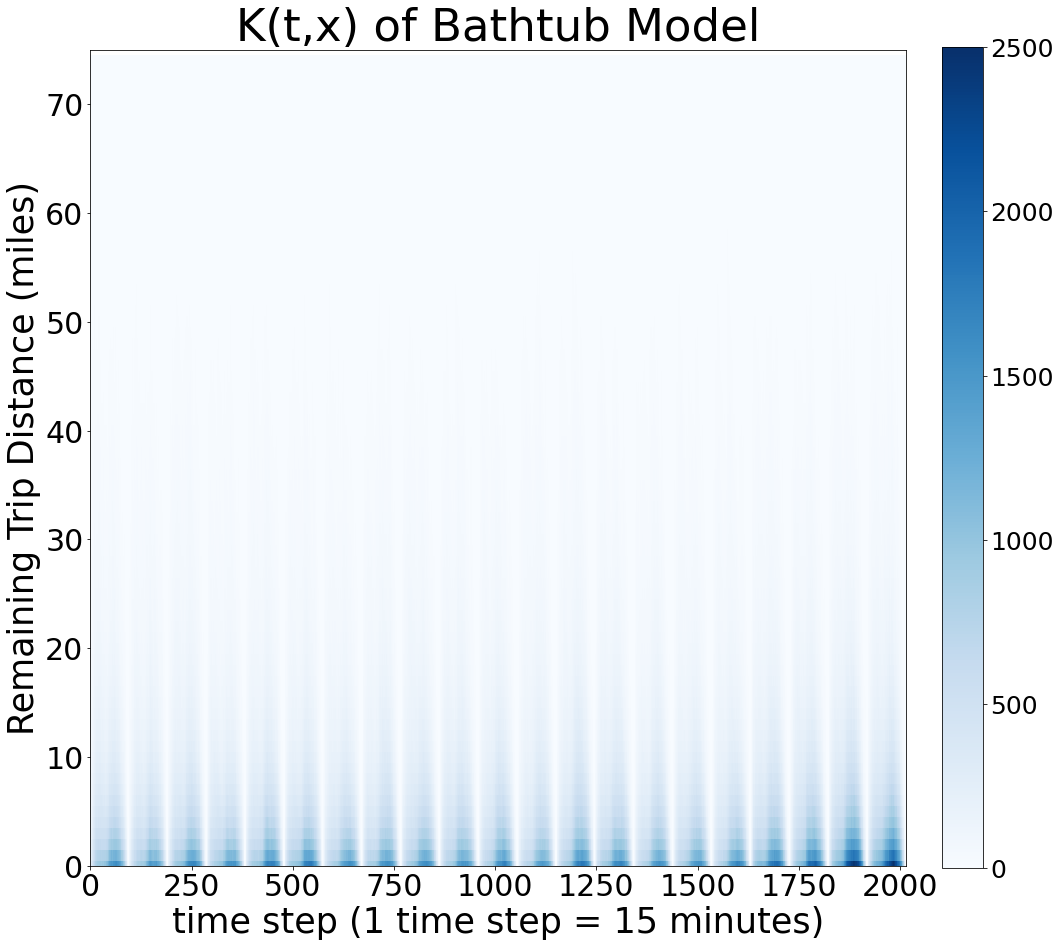

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 15 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  10080
N_u =  2016
N_f =  4032


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(2016, 2)

In [12]:
X_u_test.shape

(8064, 2)

In [13]:
X_u_train

array([[0.81081081, 0.55434243],
       [0.2027027 , 0.71960298],
       [0.        , 0.01588089],
       ...,
       [0.        , 0.27047146],
       [0.81081081, 0.49875931],
       [0.        , 0.70421836]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.031175496219327213 0.031175496219327213 0.8211915909867671
0.028037057439508361 0.028037057439508361 0.7780456795854809
0.020415842452817409 0.020415842452817409 0.6586597110848856
0.020173625206583362 0.020173625206583362 0.656405864742059
0.02011070625981129 0.02011070625981129 0.6550732345861194
0.020064290633871846 0.020064290633871846 0.6541392439204707
0.02002246137396111 0.02002246137396111 0.6534574792482394
0.019983068697664492 0.019983068697664492 0.6529036193781385
0.019783671527196157 0.019783671527196157 0.649383063344173
0.019512629224075453 0.019512629224075453 0.644387613910431
0.019083117733940957 0.019083117733940957 0.6361851994324242
0.017891419860720705 0.017891419860720705 0.6144615241598526
0.017001617732690096 0.017001617732690096 0.5992241638819642
0.016918968684788732 0.016918968684788732 0.5977139222911573
0.016721461835554365 0.016721461835554365 0.5947159678481924
0.016563355185100118 0.016563355185100118 0.5920210114555149
0.015955353617244233 0.01595535

0.0089632406583568386 0.0089632406583568386 0.4211804579585761
0.0089632113226520461 0.0089632113226520461 0.421218484698455
0.0089631836721874355 0.0089631836721874355 0.4212371558997541
0.0089631482939559626 0.0089631482939559626 0.42123739447770997
0.0089631153851953919 0.0089631153851953919 0.42121090753443746
0.0089631000679907848 0.0089631000679907848 0.4211916028607495
0.008963089403943145 0.008963089403943145 0.4211857709263288
0.0089630709261410181 0.0089630709261410181 0.42116276416765897
0.0089630292916643 0.0089630292916643 0.42118067921874836
0.0089629497118629484 0.0089629497118629484 0.4212550047286107
0.0089627437009484646 0.0089627437009484646 0.42117251080181545
0.0089625714276417145 0.0089625714276417145 0.42110866411850656
0.0089623116942686275 0.0089623116942686275 0.42114820738455183
0.00896217800570629 0.00896217800570629 0.42099903509424547
0.00896197442891829 0.00896197442891829 0.42107284586679017
0.0089618327722122814 0.0089618327722122814 0.4211474505609079


0.0089547385540302178 0.0089547385540302178 0.4205573737283256
0.0089546323087006871 0.0089546323087006871 0.4205610570703223
0.008954560239400413 0.008954560239400413 0.42055290869213285
0.008954534289408551 0.008954534289408551 0.42052257535831805
0.0089545161592226967 0.0089545161592226967 0.42056443593895937
0.0089545113473033025 0.0089545113473033025 0.42056222428808315
0.0089545077349886225 0.0089545077349886225 0.42055810381994474
0.0089545051945829138 0.0089545051945829138 0.42055485865772996
0.0089544999668212041 0.0089544999668212041 0.4205588223610473
0.0089544665243611737 0.0089544665243611737 0.4205788783600658
0.008954433100283132 0.008954433100283132 0.4206009686863548
0.00895440125460675 0.00895440125460675 0.42062039442357496
0.0089543779677669424 0.0089543779677669424 0.4206004179140859
0.0089543665763617327 0.0089543665763617327 0.42059262314346046
0.0089543594815769349 0.0089543594815769349 0.4205826831723371
0.0089543439032080431 0.0089543439032080431 0.42057694978

0.008952227741851412 0.008952227741851412 0.4204935385288729
0.00895220866367412 0.00895220866367412 0.4205053018549243
0.0089522023777809673 0.0089522023777809673 0.42050163060370604
0.0089521996634717837 0.0089521996634717837 0.42050016417765324
0.00895219607010712 0.00895219607010712 0.42050473330359134
0.0089521923895339445 0.0089521923895339445 0.4205062081300622
0.0089521883437085389 0.0089521883437085389 0.420506164443025
0.0089521815962572415 0.0089521815962572415 0.4205112081191633
0.008952176510522606 0.008952176510522606 0.4205106986237159
0.0089521685508160836 0.0089521685508160836 0.420508584624795
0.0089521487623600588 0.0089521487623600588 0.4205060618123529
0.0089521336496648438 0.0089521336496648438 0.4204843967898918
0.0089521184509605122 0.0089521184509605122 0.42049069503441555
0.0089521138463166568 0.0089521138463166568 0.4204969145025674
0.0089521074445225758 0.0089521074445225758 0.42050890811177755
0.0089521004132051829 0.0089521004132051829 0.42051583443659907


0.0089431919013546728 0.0089431919013546728 0.42031677310814963
0.0089431482678536869 0.0089431482678536869 0.4203661283106565
0.0089431170512600244 0.0089431170512600244 0.4203514992276288
0.0089430290649060388 0.0089430290649060388 0.4203316507701469
0.008942952387339529 0.008942952387339529 0.42032318691613935
0.0089428562515166728 0.0089428562515166728 0.4203382979395384
0.0089428019154494075 0.0089428019154494075 0.4203445482119946
0.008942785447356081 0.008942785447356081 0.42039088179280143
0.0089426989571471521 0.0089426989571471521 0.42038449165954334
0.0089426382573372 0.0089426382573372 0.42037997852982195
0.0089425528231771023 0.0089425528231771023 0.4203794320142572
0.0089424582820710509 0.0089424582820710509 0.4203722275553772
0.0089423566984957615 0.0089423566984957615 0.4203823997975366
0.0089423551983776779 0.0089423551983776779 0.4203715509815908
0.0089423054106892112 0.0089423054106892112 0.4203890390854403
0.0089422983801518124 0.0089422983801518124 0.42039957677964

0.0089143355080334337 0.0089143355080334337 0.42025237809581567
0.0089142911277982958 0.0089142911277982958 0.42028325241785636
0.0089142742364970145 0.0089142742364970145 0.42031042057148627
0.0089142047259807688 0.0089142047259807688 0.4202362845677647
0.0089141800422663526 0.0089141800422663526 0.42022396785635663
0.0089140939016639359 0.0089140939016639359 0.42025595538551386
0.0089140637636879287 0.0089140637636879287 0.4202437503232615
0.0089140196263659249 0.0089140196263659249 0.42024292486673126
0.0089139584063097337 0.0089139584063097337 0.42014757047660434
0.008913871971005535 0.008913871971005535 0.4201972209881832
0.00891356145715735 0.00891356145715735 0.4202896781631324
0.0089134825705686777 0.0089134825705686777 0.42023537716508136
0.008913319339219709 0.008913319339219709 0.42011860274513435
0.0089131951570362179 0.0089131951570362179 0.42010436701814585
0.0089129005403476291 0.0089129005403476291 0.4201356220105364
0.0089124330768772433 0.0089124330768772433 0.4202475

0.00890729199468935 0.00890729199468935 0.4201472150666973
0.0089072727376896168 0.0089072727376896168 0.42016028141412165
0.00890722316421022 0.00890722316421022 0.42017510656245405
0.0089071818604095059 0.0089071818604095059 0.42018138609015276
0.0089071393839174114 0.0089071393839174114 0.4201576860122504
0.0089071015657401029 0.0089071015657401029 0.42016095564086636
0.0089070631554037365 0.0089070631554037365 0.4201395639660723
0.0089070358480013191 0.0089070358480013191 0.4201609576684426
0.0089070076366087342 0.0089070076366087342 0.4201480346766697
0.008906987494860177 0.008906987494860177 0.4200980979586861
0.0089069650950311975 0.0089069650950311975 0.4201577041419057
0.008906946777630315 0.008906946777630315 0.42014665165466586
0.0089069408422566311 0.0089069408422566311 0.4201527880293827
0.0089069305002039672 0.0089069305002039672 0.42013723649555423
0.0089069261810983888 0.0089069261810983888 0.420141976230107
0.0089069234030803059 0.0089069234030803059 0.4201418532313613

0.0089034884108803534 0.0089034884108803534 0.42027348718268576
0.0089034731119564427 0.0089034731119564427 0.42029826983510743
0.0089034291012577964 0.0089034291012577964 0.4202262344807001
0.00890339078297702 0.00890339078297702 0.42026119318766025
0.00890336647356597 0.00890336647356597 0.42028864482317396
0.00890328550851894 0.00890328550851894 0.42030856411384687
0.0089032156021764883 0.0089032156021764883 0.4202941041553203
0.0089031738298225218 0.0089031738298225218 0.4203284922246536
0.0089031065575407662 0.0089031065575407662 0.42032723725028404
0.00890300048737538 0.00890300048737538 0.4202665905407736
0.0089029495073961878 0.0089029495073961878 0.42029968015807834
0.0089027791110021862 0.0089027791110021862 0.42026471040353275
0.0089026887070273383 0.0089026887070273383 0.4201893080968036
0.00890259412787927 0.00890259412787927 0.4202672323090769
0.0089025709706597265 0.0089025709706597265 0.4202675506484313
0.0089024955551779278 0.0089024955551779278 0.4202419090352457
0.00

0.0089001220154910285 0.0089001220154910285 0.42017690343071806
0.008900121274981557 0.008900121274981557 0.4201790548781747
0.00890012001127142 0.00890012001127142 0.4201845225170021
0.0089001188171383416 0.0089001188171383416 0.4201874984057727
0.0089001176490297873 0.0089001176490297873 0.4201849178021372
0.0089001169428159135 0.0089001169428159135 0.42018099098053036
0.0089001160146166877 0.0089001160146166877 0.4201842768327936
0.0089001141116259435 0.0089001141116259435 0.4201732304278395
0.0089001119354173812 0.0089001119354173812 0.42017311015631986
0.0089001085237848786 0.0089001085237848786 0.4201682490461449
0.00890010402601408 0.00890010402601408 0.4201740508912152
0.0089000992112494553 0.0089000992112494553 0.4201974868471086
0.0089000930905038158 0.0089000930905038158 0.4201855367665578
0.0089000833153950309 0.0089000833153950309 0.42014536805502445
0.0089000789565709722 0.0089000789565709722 0.4201513459533054
0.0089000731312654062 0.0089000731312654062 0.420166682296843

0.0088985947739649452 0.0088985947739649452 0.4201692883185811
0.0088985904910719674 0.0088985904910719674 0.4201748604909985
0.0088985816190615824 0.0088985816190615824 0.4201822230712876
0.0088985746499448959 0.0088985746499448959 0.42017865274040034
0.0088985672859216627 0.0088985672859216627 0.42018734610311803
0.0088985625292600738 0.0088985625292600738 0.42018316986109355
0.0088985575976077858 0.0088985575976077858 0.4201805694510914
0.0088985524001345909 0.0088985524001345909 0.42019730362121177
0.00889854295703261 0.00889854295703261 0.4201943995778087
0.0088985338272010855 0.0088985338272010855 0.42019245676721084
0.00889851417664214 0.00889851417664214 0.42018992511365866
0.0088984567813820015 0.0088984567813820015 0.42018319857067676
0.0088983612148450589 0.0088983612148450589 0.42014948732487417
0.0088983259743644436 0.0088983259743644436 0.4201429407052504
0.0088982828090581334 0.0088982828090581334 0.42009741108468235
0.0088982531438067825 0.0088982531438067825 0.42014053

0.00889712533622654 0.00889712533622654 0.42027062511254054
0.00889707519999765 0.00889707519999765 0.4202033560840031
0.0088970379949924565 0.0088970379949924565 0.4202289823276573
0.0088969958069048168 0.0088969958069048168 0.42027047207518947
0.008896924547889264 0.008896924547889264 0.42027954889949365
0.00889681716167797 0.00889681716167797 0.4203014696913594
0.0088967214273412976 0.0088967214273412976 0.4202325878254851
0.0088966399545259648 0.0088966399545259648 0.42027082329341575
0.00889637899376164 0.00889637899376164 0.42030433055576877
0.0088962518590613646 0.0088962518590613646 0.42022635082738996
0.0088961476028267972 0.0088961476028267972 0.4202873260640425
0.0088960462611575083 0.0088960462611575083 0.4203164469313474
0.0088957898015693537 0.0088957898015693537 0.42027972803256614
0.0088956671935396681 0.0088956671935396681 0.4202033063352099
0.0088955693238799965 0.0088955693238799965 0.4202576059259406
0.0088954307649380844 0.0088954307649380844 0.42033152705160787
0.

0.0088308809445133557 0.0088308809445133557 0.42031303426240835
0.008829212800077299 0.008829212800077299 0.4202950078158703
0.0088265163754296539 0.0088265163754296539 0.4205880047464511
0.0088240270735535278 0.0088240270735535278 0.42078336834574603
0.0088133644585180262 0.0088133644585180262 0.4213342821001191
0.0088087030131226724 0.0088087030131226724 0.4215521347300093
0.0088070272848553913 0.0088070272848553913 0.4212614327685587
0.0087955094959578164 0.0087955094959578164 0.4200620552623583
0.00878841162345303 0.00878841162345303 0.4209949317070305
0.0087829779926652252 0.0087829779926652252 0.4209250475153649
0.0087822766339947268 0.0087822766339947268 0.4202300324790437
0.0087811545004360548 0.0087811545004360548 0.42028892297183434
0.0087793655875602911 0.0087793655875602911 0.4201009404717619
0.0087772159655716726 0.0087772159655716726 0.4205241073387821
0.008775852398749534 0.008775852398749534 0.42058739663375705
0.0087741702794379116 0.0087741702794379116 0.4205625013356

0.0087220143028753083 0.0087220143028753083 0.42442139744112906
0.0087218034794573664 0.0087218034794573664 0.4244184153044078
0.0087216408131178588 0.0087216408131178588 0.4244293529857022
0.00872136063627139 0.00872136063627139 0.42443266842384053
0.008721252452946875 0.008721252452946875 0.4243067607098711
0.0087211684469617363 0.0087211684469617363 0.42433975559270326
0.0087211142156635967 0.0087211142156635967 0.42434996673871733
0.0087210644773297544 0.0087210644773297544 0.42426552908610254
0.008720904317244059 0.008720904317244059 0.424234670450952
0.00872079301861025 0.00872079301861025 0.4241368710803396
0.0087205255428705383 0.0087205255428705383 0.4240700628556094
0.0087202876256471 0.0087202876256471 0.42410626905691673
0.00872015317668029 0.00872015317668029 0.42399404167454013
0.0087200628842173562 0.0087200628842173562 0.4238358480806026
0.008719984745780231 0.008719984745780231 0.4238963133279956
0.00871992730245283 0.00871992730245283 0.4238726935321821
0.008719906100

0.0087052809259993529 0.0087052809259993529 0.4224505630580809
0.00870494308944406 0.00870494308944406 0.4225573485752427
0.0087043323486797781 0.0087043323486797781 0.42253421969436983
0.0087032943235615615 0.0087032943235615615 0.423013285060061
0.0087026958914015583 0.0087026958914015583 0.42303139508735604
0.0087021251579106774 0.0087021251579106774 0.4231403126350663
0.0087013818563253069 0.0087013818563253069 0.42280891680731075
0.0087011757839519071 0.0087011757839519071 0.4229608181249397
0.0087009018245189414 0.0087009018245189414 0.42286343266847115
0.0087006749761437581 0.0087006749761437581 0.4228603225591409
0.008700423243804406 0.008700423243804406 0.4228021825944742
0.0087002269759709015 0.0087002269759709015 0.422900906176121
0.0087000788626234657 0.0087000788626234657 0.4228329340747581
0.0086999011104398442 0.0086999011104398442 0.4229415393192104
0.0086997983496313776 0.0086997983496313776 0.4229363508143915
0.0086996157851467627 0.0086996157851467627 0.4229120518208

0.0086700864463331549 0.0086700864463331549 0.423416831696931
0.00866995908345432 0.00866995908345432 0.4234152743085202
0.0086698106352813865 0.0086698106352813865 0.4234347290569113
0.00866968176384382 0.00866968176384382 0.4234052261245102
0.0086694976771057967 0.0086694976771057967 0.42337332947391887
0.008669282684609916 0.008669282684609916 0.4234013134240378
0.0086688772711921765 0.0086688772711921765 0.4234063407064525
0.0086686795734025619 0.0086686795734025619 0.4234494171525393
0.0086684042785334613 0.0086684042785334613 0.42330300785091374
0.0086682909363794917 0.0086682909363794917 0.4233792377169837
0.00866817083209498 0.00866817083209498 0.4233511953100114
0.008667908454524224 0.008667908454524224 0.42335560322794774
0.00866758535364211 0.00866758535364211 0.42334720991018343
0.008667323172780711 0.008667323172780711 0.42328266801394143
0.0086671526800084081 0.0086671526800084081 0.4233752018814321
0.00866697084344697 0.00866697084344697 0.4233346309450108
0.008666852267

0.0086447145239888709 0.0086447145239888709 0.42365953659398575
0.0086433093710940531 0.0086433093710940531 0.423420894420282
0.0086418712322770767 0.0086418712322770767 0.42332458885046303
0.0086413128741979761 0.0086413128741979761 0.42349307988481133
0.0086410876805685342 0.0086410876805685342 0.4233813123047796
0.0086404449102958983 0.0086404449102958983 0.4233235156305561
0.0086397793424149369 0.0086397793424149369 0.4232966726068591
0.0086391509713509666 0.0086391509713509666 0.4234226138091111
0.0086388078414077578 0.0086388078414077578 0.4233745856727571
0.0086384399604321482 0.0086384399604321482 0.42346698565986063
0.0086380507047028859 0.0086380507047028859 0.4233891641447007
0.0086376557698753641 0.0086376557698753641 0.42347618966817896
0.0086373404930816834 0.0086373404930816834 0.42351508535659477
0.0086370182254113959 0.0086370182254113959 0.42346909690365403
0.0086368339268790544 0.0086368339268790544 0.42307908718832604
0.0086364483148319814 0.0086364483148319814 0.42

0.0084457635297553648 0.0084457635297553648 0.4162705391374962
0.0084442437307063484 0.0084442437307063484 0.4165107203978807
0.008442977335892457 0.008442977335892457 0.41649418170652186
0.008441484350586571 0.008441484350586571 0.41649985452239185
0.00844015440401587 0.00844015440401587 0.4162125860040513
0.0084390876498459822 0.0084390876498459822 0.41653227854602876
0.008438130406720196 0.008438130406720196 0.41626961711704763
0.0084370518074116645 0.0084370518074116645 0.41607625099999596
0.0084360614906186 0.0084360614906186 0.4160854902442634
0.0084351925984304781 0.0084351925984304781 0.41609281281114857
0.008434316562092814 0.008434316562092814 0.41594159272464976
0.008433552146796832 0.008433552146796832 0.4160777846616909
0.0084311158045595261 0.0084311158045595261 0.41587907678306896
0.0084293509223534752 0.0084293509223534752 0.41589735358757024
0.0084276816787585314 0.0084276816787585314 0.41576004168555164
0.0084270257749322289 0.0084270257749322289 0.4157857490829324
0.

0.0083883346159595949 0.0083883346159595949 0.416053394796568
0.0083876401222497728 0.0083876401222497728 0.41600655109635404
0.0083871949357682083 0.0083871949357682083 0.4158982729831109
0.0083867368709012215 0.0083867368709012215 0.41583505300829904
0.0083864741923429763 0.0083864741923429763 0.4157997086680526
0.0083862506532144457 0.0083862506532144457 0.4157224429291174
0.0083861605976716241 0.0083861605976716241 0.41577179730131736
0.0083860875406491023 0.0083860875406491023 0.41571092816313837
0.0083859391482083243 0.0083859391482083243 0.41579680540615505
0.0083858609224944786 0.0083858609224944786 0.4157620863508705
0.0083857806241943254 0.0083857806241943254 0.41576909082446417
0.008385702753140661 0.008385702753140661 0.4157717482419658
0.0083856740740669827 0.0083856740740669827 0.41579462276319995
0.0083856052412003383 0.0083856052412003383 0.41578991451997127
0.0083855609467481784 0.0083855609467481784 0.41580290441663226
0.0083855196954306811 0.0083855196954306811 0.415

0.00828744022714875 0.00828744022714875 0.41393643157451515
0.0082867974449789984 0.0082867974449789984 0.4140770360800079
0.008286339020147972 0.008286339020147972 0.4139964400089733
0.00828583025447207 0.00828583025447207 0.41399078660216265
0.008285287791652652 0.008285287791652652 0.41402822211307966
0.008284319289985893 0.008284319289985893 0.41425956574861755
0.0082838816501709031 0.0082838816501709031 0.41429000962149365
0.008283547276569941 0.008283547276569941 0.41447207571552125
0.0082832975891493823 0.0082832975891493823 0.4144565069043989
0.0082831173367434764 0.0082831173367434764 0.414386077814364
0.0082830018544123047 0.0082830018544123047 0.41439464159136025
0.0082828859258212862 0.0082828859258212862 0.4143843795402081
0.00828271172002463 0.00828271172002463 0.414277288993859
0.00828263578637434 0.00828263578637434 0.4142342752861907
0.0082825145089655168 0.0082825145089655168 0.41424013221876704
0.00828226870010282 0.00828226870010282 0.4142377531315466
0.008281975846

0.0081803352784072369 0.0081803352784072369 0.41155015039401677
0.0081799054953388614 0.0081799054953388614 0.4115484470049598
0.0081790348107553534 0.0081790348107553534 0.4114042741656227
0.0081780881927425771 0.0081780881927425771 0.41146609380376387
0.0081764935524545473 0.0081764935524545473 0.4111861102118015
0.00817565013905535 0.00817565013905535 0.41107701979890926
0.0081747817342574629 0.0081747817342574629 0.41081591099283304
0.0081743436438838253 0.0081743436438838253 0.4109359982837423
0.0081737743833663716 0.0081737743833663716 0.4109731350444552
0.0081730095371648562 0.0081730095371648562 0.410865042032428
0.0081725629217929557 0.0081725629217929557 0.4108627528622113
0.00817185963483032 0.00817185963483032 0.4108609000269375
0.0081712185500949757 0.0081712185500949757 0.4105843299052194
0.0081704053753762582 0.0081704053753762582 0.4106980070989974
0.0081696406084055574 0.0081696406084055574 0.41108806709614193
0.0081690098187823315 0.0081690098187823315 0.4109260334548

0.00805994898574473 0.00805994898574473 0.4100866087455371
0.0080580887213531471 0.0080580887213531471 0.4101321239177352
0.0080571753724325967 0.0080571753724325967 0.4107616686648167
0.0080558464431270214 0.0080558464431270214 0.41089340839044636
0.008054159101940947 0.008054159101940947 0.41039058028883324
0.0080532160450664178 0.0080532160450664178 0.4107582028730994
0.0080514840904006933 0.0080514840904006933 0.41071985152174567
0.00804996392497692 0.00804996392497692 0.41067712949574686
0.0080490039400276589 0.0080490039400276589 0.41079643986279557
0.0080480378039683321 0.0080480378039683321 0.4108764935104657
0.00804771660783631 0.00804771660783631 0.41059109482993333
0.0080472776278537224 0.0080472776278537224 0.4106793239958815
0.00804619281685183 0.00804619281685183 0.41085603285830724
0.0080449830889594547 0.0080449830889594547 0.4110854105759752
0.00804412988043451 0.00804412988043451 0.41098150818255863
0.0080422608465983529 0.0080422608465983529 0.41094726087322314
0.008

0.0079949054506661416 0.0079949054506661416 0.41108694256571304
0.007994766939606917 0.007994766939606917 0.4110574714297911
0.0079944419768117614 0.0079944419768117614 0.41121353233053975
0.0079942262236692273 0.0079942262236692273 0.4113115260580689
0.0079940541029181 0.0079940541029181 0.41121435420989993
0.0079937738504599152 0.0079937738504599152 0.4113428335880584
0.0079934241868749242 0.0079934241868749242 0.4113365866451255
0.0079928251236668062 0.0079928251236668062 0.41120453958735853
0.0079923143578967 0.0079923143578967 0.4113271772903781
0.00799144798096485 0.00799144798096485 0.4113807161734917
0.0079912786376843976 0.0079912786376843976 0.41178790858560826
0.0079906049627801231 0.0079906049627801231 0.4115310343177834
0.0079900457903962739 0.0079900457903962739 0.41144869539195056
0.0079893809978336186 0.0079893809978336186 0.41168614837809414
0.0079881179563795323 0.0079881179563795323 0.4117394815531593
0.0079867520652902816 0.0079867520652902816 0.41165476169719245
0.

0.0077934355241271718 0.0077934355241271718 0.4070663525271201
0.0077899848696705975 0.0077899848696705975 0.4077296795871387
0.0077884160001520748 0.0077884160001520748 0.40782789066873554
0.0077863487604808287 0.0077863487604808287 0.4073414577114854
0.0077858079382999868 0.0077858079382999868 0.40706728177808027
0.0077849065296352691 0.0077849065296352691 0.40729970969285967
0.0077843991541697213 0.0077843991541697213 0.40733023547826813
0.0077837416595127962 0.0077837416595127962 0.4073460391977633
0.0077827513658830089 0.0077827513658830089 0.40733374680902873
0.0077820700318637975 0.0077820700318637975 0.40731682467254765
0.0077814940475760047 0.0077814940475760047 0.40735701089846754
0.007780820306566248 0.007780820306566248 0.40727793245951693
0.0077799254330828847 0.0077799254330828847 0.40733431842557116
0.00777865024297408 0.00777865024297408 0.4072017626927849
0.0077770245095000433 0.0077770245095000433 0.4069490572094313
0.0077756359728873648 0.0077756359728873648 0.406549

0.0072795051333798839 0.0072795051333798839 0.4026100584032454
0.007253332600145837 0.007253332600145837 0.40193769943464686
0.007231485482445405 0.007231485482445405 0.401136340669849
0.0072025938761174167 0.0072025938761174167 0.4005471178797743
0.00718249306604349 0.00718249306604349 0.39993735436780103
0.00716695679236177 0.00716695679236177 0.4022300625642706
0.0071501387735560312 0.0071501387735560312 0.4007003226499949
0.007136894926639748 0.007136894926639748 0.3976852776499085
0.0071301121375506706 0.0071301121375506706 0.399040637550261
0.0071166274038306455 0.0071166274038306455 0.39874094736059573
0.00710528298204036 0.00710528298204036 0.3988758190915427
0.0070880224125104557 0.0070880224125104557 0.39842034638454055
0.00705536926434472 0.00705536926434472 0.3983747629923586
0.0070448546857853934 0.0070448546857853934 0.39909754149073834
0.0070308233135350532 0.0070308233135350532 0.3987998863290996
0.00702251481721202 0.00702251481721202 0.3993516779413033
0.0070184306127

0.0067572981301016032 0.0067572981301016032 0.39505057819442685
0.0067529714079460641 0.0067529714079460641 0.3951212442188405
0.0067452534613216333 0.0067452534613216333 0.3960820629864421
0.0067387624218768656 0.0067387624218768656 0.3968359811927048
0.0067295070002483474 0.0067295070002483474 0.3964342460793894
0.0067073600469960944 0.0067073600469960944 0.39555867547322854
0.0066820168443007741 0.0066820168443007741 0.394419626434258
0.0066782681991482424 0.0066782681991482424 0.39370118597342707
0.0066724576971431936 0.0066724576971431936 0.3932639603396016
0.0066704357492833157 0.0066704357492833157 0.39282757237506666
0.0066689970330378618 0.0066689970330378618 0.39286615443570605
0.006667411830649065 0.006667411830649065 0.39252315180881137
0.0066663541869565511 0.0066663541869565511 0.3926523399000556
0.0066651708200224343 0.0066651708200224343 0.39249335364857096
0.0066638426587363369 0.0066638426587363369 0.3923103885748059
0.0066630380324641855 0.0066630380324641855 0.39207

0.0059618604056128829 0.0059618604056128829 0.37897115622660343
0.0059599442642975856 0.0059599442642975856 0.37911118242319014
0.0059559144495190553 0.0059559144495190553 0.37984132987820524
0.0059548811498693162 0.0059548811498693162 0.3795792795750023
0.0059510372825805425 0.0059510372825805425 0.3791492730714784
0.0059478169637491333 0.0059478169637491333 0.37859730892092486
0.0059464455400231346 0.0059464455400231346 0.37922235193689857
0.0059431803521194718 0.0059431803521194718 0.3788118446267279
0.005941873550485784 0.005941873550485784 0.3789687339814847
0.00594003361276595 0.00594003361276595 0.3790655332784141
0.0059385485228592326 0.0059385485228592326 0.37881554534051765
0.0059370027044583105 0.0059370027044583105 0.37895699037324543
0.0059363596247562263 0.0059363596247562263 0.3789686730708313
0.0059358434090673309 0.0059358434090673309 0.37922664587406574
0.0059356017669222 0.0059356017669222 0.3791482300023185
0.00593518088063508 0.00593518088063508 0.3792142580699392


0.0057498586842856681 0.0057498586842856681 0.37221793441421375
0.0057485728453274725 0.0057485728453274725 0.3720983744181964
0.005748353970791549 0.005748353970791549 0.37172483433010417
0.0057469932759751279 0.0057469932759751279 0.37179775858581604
0.0057460614211260709 0.0057460614211260709 0.37187635517290774
0.0057455071176288966 0.0057455071176288966 0.3720123604010742
0.0057450574703401744 0.0057450574703401744 0.3719653208755535
0.0057448140594829585 0.0057448140594829585 0.3720176980813678
0.0057445610971668341 0.0057445610971668341 0.37196371209318024
0.00574433954335924 0.00574433954335924 0.37202503718086705
0.00574364567645344 0.00574364567645344 0.3721559299393677
0.0057428855209881889 0.0057428855209881889 0.37243911562728693
0.005741357935148776 0.005741357935148776 0.37245498084305223
0.0057397376841038291 0.0057397376841038291 0.37231161276642805
0.0057380753022770415 0.0057380753022770415 0.3724584315013757
0.0057364101579390567 0.0057364101579390567 0.372527982589

0.0053658581723969668 0.0053658581723969668 0.3592290593187312
0.005365597544674236 0.005365597544674236 0.3590713566086724
0.0053652811193293714 0.0053652811193293714 0.3589200951515761
0.0053648801857461509 0.0053648801857461509 0.358820870667706
0.0053638008332639233 0.0053638008332639233 0.3587079283250062
0.0053618817489335009 0.0053618817489335009 0.3585820770127928
0.0053590694283405351 0.0053590694283405351 0.35854716217336896
0.00535634297523306 0.00535634297523306 0.3585508143010214
0.00535515129460981 0.00535515129460981 0.35875873913878725
0.0053534091531439029 0.0053534091531439029 0.35857138528388804
0.0053525992524310955 0.0053525992524310955 0.35853260092576383
0.0053521584707934078 0.0053521584707934078 0.3584990400895235
0.00535167939907107 0.00535167939907107 0.3584688031559922
0.005351115454717629 0.005351115454717629 0.35834169990953746
0.0053501520571724364 0.0053501520571724364 0.35829065505409136
0.0053489589049291689 0.0053489589049291689 0.3583142470677709
0.0

0.0051029215915905065 0.0051029215915905065 0.34973791133877613
0.0050978317615690419 0.0050978317615690419 0.34950485366713324
0.0050950347496280385 0.0050950347496280385 0.34993744867640647
0.0050939154847132635 0.0050939154847132635 0.3498828779214194
0.0050921897452816606 0.0050921897452816606 0.3497370273481741
0.00509065032801012 0.00509065032801012 0.34972411662225067
0.0050897954203705832 0.0050897954203705832 0.34975989577782723
0.0050877681419276895 0.0050877681419276895 0.34984367735196376
0.0050855957711656722 0.0050855957711656722 0.3497962941769795
0.0050836280823972537 0.0050836280823972537 0.34980298510040925
0.0050777751631905744 0.0050777751631905744 0.3496345176437015
0.0050763180807322133 0.0050763180807322133 0.3492460963040261
0.005073902056847027 0.005073902056847027 0.34934721238627087
0.0050721442593759155 0.0050721442593759155 0.3492834953290516
0.0050694533333257609 0.0050694533333257609 0.34933610051344227
0.0050659938591768958 0.0050659938591768958 0.349342

0.0050311044995030542 0.0050311044995030542 0.34755941978546046
0.0050294335662743475 0.0050294335662743475 0.3475586744082946
0.0050279578379401274 0.0050279578379401274 0.34774643250454484
0.0050266369881816946 0.0050266369881816946 0.347879349550904
0.0050259462881895051 0.0050259462881895051 0.3481404187813617
0.0050248639485114648 0.0050248639485114648 0.3480475408765858
0.005024521973806568 0.005024521973806568 0.3480643506900954
0.0050234069369547944 0.0050234069369547944 0.347930360559446
0.0050226333518392013 0.0050226333518392013 0.3480452870220691
0.0050216965777589119 0.0050216965777589119 0.3480780683642247
0.0050204316073774605 0.0050204316073774605 0.3479844244892746
0.0050200442740667645 0.0050200442740667645 0.34801986616143826
0.0050190950054429511 0.0050190950054429511 0.34790075180064445
0.0050180418612207831 0.0050180418612207831 0.3478164888884921
0.0050169578441363006 0.0050169578441363006 0.3476000573668806
0.0050160762233165453 0.0050160762233165453 0.347372958

0.0049033334817497895 0.0049033334817497895 0.34671738395810575
0.0049025057069020548 0.0049025057069020548 0.34668722453710066
0.0049009550045591111 0.0049009550045591111 0.3467006283421214
0.0048990006078145684 0.0048990006078145684 0.34698404662870613
0.0048965978084519555 0.0048965978084519555 0.3470052907412601
0.0048957390269941817 0.0048957390269941817 0.3469654089318648
0.00489436196099965 0.00489436196099965 0.34708733641844225
0.0048915447454459813 0.0048915447454459813 0.3468115879356931
0.00489105185457386 0.00489105185457386 0.34684466425407506
0.0048889327556182176 0.0048889327556182176 0.3465018606046084
0.0048879837459303238 0.0048879837459303238 0.34601939893964645
0.004886000623573715 0.004886000623573715 0.3459746063139816
0.0048844300291287536 0.0048844300291287536 0.3462663670340394
0.0048836022661661619 0.0048836022661661619 0.34639772552110404
0.0048818064283077962 0.0048818064283077962 0.34639545681169853
0.0048811901592147695 0.0048811901592147695 0.34626755596

0.0048293964428658 0.0048293964428658 0.34541015245143475
0.0048293030118588577 0.0048293030118588577 0.34541200657738036
0.0048291895982508814 0.0048291895982508814 0.3454029326534902
0.0048289802205963668 0.0048289802205963668 0.3454053955275373
0.0048289430882631672 0.0048289430882631672 0.3454088737616304
0.0048289034178674341 0.0048289034178674341 0.3453977728909911
0.0048288533065069684 0.0048288533065069684 0.3454040534579936
0.0048287694097561137 0.0048287694097561137 0.34539490154075203
0.0048286945848399 0.0048286945848399 0.34538316171397193
0.0048286632400995656 0.0048286632400995656 0.34535509891436406
0.0048285982281009807 0.0048285982281009807 0.3453714182378962
0.0048285109152109177 0.0048285109152109177 0.34536972907566565
0.0048283044430231636 0.0048283044430231636 0.3453951707924643
0.0048281203389395734 0.0048281203389395734 0.3454243380958408
0.0048279865927825594 0.0048279865927825594 0.34543796995862835
0.0048277571816522516 0.0048277571816522516 0.34547343572493

0.004783832109573314 0.004783832109573314 0.3438402889572491
0.00478368038143173 0.00478368038143173 0.3438156218014873
0.0047833934538927233 0.0047833934538927233 0.3437540646432106
0.0047832342319786029 0.0047832342319786029 0.3436751553801073
0.0047830832967686795 0.0047830832967686795 0.34359602873291306
0.004782865054059381 0.004782865054059381 0.34353767595001916
0.0047826428288244892 0.0047826428288244892 0.34342547217620234
0.0047824368347671392 0.0047824368347671392 0.34347608149553027
0.0047820593889403218 0.0047820593889403218 0.3435100619718271
0.0047816304507822946 0.0047816304507822946 0.34349961023398007
0.0047811243393843248 0.0047811243393843248 0.3436668093048849
0.0047809809135718143 0.0047809809135718143 0.34360394767305674
0.0047804494848052194 0.0047804494848052194 0.34358561070897087
0.0047801169366149324 0.0047801169366149324 0.34362750301910616
0.0047795855378297315 0.0047795855378297315 0.34351064670140474
0.00477859793167573 0.00477859793167573 0.343377339066

0.0047491038708107674 0.0047491038708107674 0.3415940351584475
0.0047482858738212754 0.0047482858738212754 0.34161030357017724
0.0047479278001763539 0.0047479278001763539 0.3415263625906515
0.00474713122674045 0.00474713122674045 0.34163325025256
0.0047469084781579119 0.0047469084781579119 0.3418337538152957
0.0047468200322807168 0.0047468200322807168 0.3416387700365154
0.0047465152462788122 0.0047465152462788122 0.341716419835049
0.0047464358617098053 0.0047464358617098053 0.34176880934187975
0.004746388807641627 0.004746388807641627 0.3417633925005952
0.004746313174689213 0.004746313174689213 0.3418225074988096
0.004746244262421504 0.004746244262421504 0.341837408036655
0.0047460987524549506 0.0047460987524549506 0.3419195337709753
0.004745993203196114 0.004745993203196114 0.3419386833821356
0.0047459262475128767 0.0047459262475128767 0.34199540442575116
0.0047458155444566911 0.0047458155444566911 0.3420242457973996
0.0047457656958864759 0.0047457656958864759 0.3420007226395752
0.004

0.0047250537173690321 0.0047250537173690321 0.3424769897368244
0.0047248228236680279 0.0047248228236680279 0.3424159044377365
0.0047247047467560109 0.0047247047467560109 0.34244185395185334
0.0047245756201630251 0.0047245756201630251 0.34239722614679335
0.0047243634679538151 0.0047243634679538151 0.3423886100456473
0.0047242222922991494 0.0047242222922991494 0.34241908153031114
0.0047239870224452564 0.0047239870224452564 0.3424397024480598
0.0047238676169315151 0.0047238676169315151 0.3424852104219211
0.004723801641828315 0.004723801641828315 0.34246985261186835
0.0047236510943377023 0.0047236510943377023 0.3424970001310862
0.0047235208250676177 0.0047235208250676177 0.3425061613670243
0.0047233111741586927 0.0047233111741586927 0.3424865131073601
0.0047232325877425551 0.0047232325877425551 0.34242700329322223
0.004722985399649055 0.004722985399649055 0.3424124418442224
0.0047229102946441679 0.0047229102946441679 0.34236547812639345
0.0047225539651334324 0.0047225539651334324 0.3423433

0.0046567201403941785 0.0046567201403941785 0.34109891280510557
0.004656189324874954 0.004656189324874954 0.3409632374798285
0.0046560472155695379 0.0046560472155695379 0.3410222674580003
0.0046558847935420419 0.0046558847935420419 0.34092859697911393
0.0046556675812373114 0.0046556675812373114 0.3409112745294237
0.0046554432993430664 0.0046554432993430664 0.34086965642364675
0.0046551694457838159 0.0046551694457838159 0.34093248334801507
0.0046550227712948275 0.0046550227712948275 0.34087328262813343
0.0046548452829264821 0.0046548452829264821 0.3407923674034457
0.0046545005603098677 0.0046545005603098677 0.3408242474410074
0.0046541009776447694 0.0046541009776447694 0.340777972126928
0.0046537757283450941 0.0046537757283450941 0.340759312988827
0.0046536293582347989 0.0046536293582347989 0.34068316074122734
0.0046535407624195895 0.0046535407624195895 0.3407399182618486
0.0046533836094958076 0.0046533836094958076 0.34065192293400726
0.0046531796065119573 0.0046531796065119573 0.340620

0.0046401187966711747 0.0046401187966711747 0.3409073876009046
0.0046400357088172105 0.0046400357088172105 0.3410163243560297
0.0046399937831052094 0.0046399937831052094 0.34101215215244757
0.00463995556649245 0.00463995556649245 0.34098229741817343
0.00463991941059409 0.00463991941059409 0.34094935053022707
0.0046399094573392075 0.0046399094573392075 0.3409700198921938
0.0046398964989102067 0.0046398964989102067 0.34096062400087973
0.004639891264013634 0.004639891264013634 0.34095081884862694
0.0046398827101386325 0.0046398827101386325 0.3409389097270142
0.0046398717578557663 0.0046398717578557663 0.3409258908812731
0.0046398467938836641 0.0046398467938836641 0.3409075640275588
0.004639804661544635 0.004639804661544635 0.3408820950913874
0.0046397824466170769 0.0046397824466170769 0.34089878451125794
0.004639662192607156 0.004639662192607156 0.3408655154561482
0.0046395278460457118 0.0046395278460457118 0.3408911730180134
0.0046393165367489813 0.0046393165367489813 0.3407776593160911


0.0045739911512586865 0.0045739911512586865 0.3375442377246645
0.0045738397704024915 0.0045738397704024915 0.33762148682723064
0.0045737472805915287 0.0045737472805915287 0.3375403091102488
0.0045736167268829384 0.0045736167268829384 0.33756206405190947
0.00457340068286219 0.00457340068286219 0.33757259450931865
0.0045731894064506727 0.0045731894064506727 0.3375215416432131
0.0045729361509922765 0.0045729361509922765 0.3374323665100971
0.0045728034309805241 0.0045728034309805241 0.3373635666109244
0.0045726833805867671 0.0045726833805867671 0.3373848401594704
0.0045725661060629329 0.0045725661060629329 0.3374031397402752
0.0045724867674590327 0.0045724867674590327 0.3373946985971924
0.0045723151606387527 0.0045723151606387527 0.33748904938464624
0.0045721984795827645 0.0045721984795827645 0.33740715771018187
0.0045720743791340061 0.0045720743791340061 0.33735333040575044
0.0045719320584108759 0.0045719320584108759 0.3373182671366948
0.0045717598965765126 0.0045717598965765126 0.3372956

0.0045550564999552222 0.0045550564999552222 0.33570949070109724
0.004554986118874455 0.004554986118874455 0.33568377121735776
0.0045548035629888262 0.0045548035629888262 0.3357470731861096
0.0045546742006871621 0.0045546742006871621 0.33573139184706363
0.0045545518002844546 0.0045545518002844546 0.3357469244052029
0.00455441295005243 0.00455441295005243 0.33571838988366376
0.0045543340489784421 0.0045543340489784421 0.33572073785239565
0.0045541938925769358 0.0045541938925769358 0.33565341881880595
0.0045540656432292064 0.0045540656432292064 0.3356979119431965
0.0045538927078404463 0.0045538927078404463 0.33571103270490943
0.0045537292506329539 0.0045537292506329539 0.33561371811834184
0.0045536724392208888 0.0045536724392208888 0.335636349693953
0.0045535856755125927 0.0045535856755125927 0.3356361648978254
0.0045535542119896 0.0045535542119896 0.33562244316608303
0.004553505086893307 0.004553505086893307 0.3356685758071408
0.004553476351532749 0.004553476351532749 0.33564499731482994

0.004510963716864211 0.004510963716864211 0.3344383737572815
0.0045108421882709537 0.0045108421882709537 0.33437100351466575
0.0045106807989587 0.0045106807989587 0.3343259952941944
0.0045104832890579529 0.0045104832890579529 0.33432065269269573
0.0045104765423268425 0.0045104765423268425 0.33432787276274767
0.0045103669556374841 0.0045103669556374841 0.33430716685011774
0.0045102469974526178 0.0045102469974526178 0.3343380639606148
0.0045101450010730073 0.0045101450010730073 0.3343190818384785
0.004510017499805178 0.004510017499805178 0.3343062985207616
0.0045097926159403589 0.0045097926159403589 0.33428259590147563
0.004509304538318065 0.004509304538318065 0.3342409785818899
0.004508983265959444 0.004508983265959444 0.3342437889576812
0.0045087306245027662 0.0045087306245027662 0.3342066891313639
0.004508523693491525 0.004508523693491525 0.3342226421469705
0.0045083764299836517 0.0045083764299836517 0.3342479601572052
0.0045082650465747042 0.0045082650465747042 0.3342229771516773
0.0

0.0044817696907510588 0.0044817696907510588 0.3347207466991278
0.00448154464580641 0.00448154464580641 0.33454228012354736
0.0044813047467152116 0.0044813047467152116 0.3345574459275754
0.0044812964186712531 0.0044812964186712531 0.33457982983235385
0.0044810345722938877 0.0044810345722938877 0.3346060051127894
0.0044806912134513974 0.0044806912134513974 0.33456983183250905
0.0044804264914031682 0.0044804264914031682 0.33453051727538785
0.0044802283913282582 0.0044802283913282582 0.33452554099224885
0.0044801891098178188 0.0044801891098178188 0.3345727550882031
0.0044799672032198382 0.0044799672032198382 0.3345005657022319
0.00447990148976926 0.00447990148976926 0.3344933231966137
0.0044798458457195349 0.0044798458457195349 0.33445431975347856
0.0044797443272121071 0.0044797443272121071 0.3344911894627597
0.0044797213524415984 0.0044797213524415984 0.33450306496640886
0.004479526125868675 0.004479526125868675 0.3345290273941264
0.0044792645109351884 0.0044792645109351884 0.334585236433

0.0044643512496826705 0.0044643512496826705 0.33333801329833307
0.0044641104694746 0.0044641104694746 0.33318055317135753
0.0044639372266978812 0.0044639372266978812 0.3331293980037973
0.004463749981413084 0.004463749981413084 0.3330514194522769
0.0044635537733820349 0.0044635537733820349 0.3331139470887781
0.0044634756959079213 0.0044634756959079213 0.33305130761325763
0.00446338756715333 0.00446338756715333 0.33302682473430734
0.0044631987733051966 0.0044631987733051966 0.3330045382205922
0.00446307220653514 0.00446307220653514 0.33299202665864125
0.00446284109037994 0.00446284109037994 0.3329717655360252
0.0044625365539624371 0.0044625365539624371 0.33277284196904305
0.0044623545513016762 0.0044623545513016762 0.33288821311168926
0.0044622146151477686 0.0044622146151477686 0.33288455375344267
0.0044619992470894239 0.0044619992470894239 0.33286081156261715
0.0044618246308987886 0.0044618246308987886 0.3328572596548305
0.0044617116601134406 0.0044617116601134406 0.3329229090184012
0.0

0.004452143120459791 0.004452143120459791 0.33276151765984585
0.0044520903756456115 0.0044520903756456115 0.33273196566194047
0.0044520646560886707 0.0044520646560886707 0.3327269223601111
0.0044520313254663027 0.0044520313254663027 0.33271137165271375
0.0044519857996737919 0.0044519857996737919 0.33269851475203266
0.0044519388942390412 0.0044519388942390412 0.33271714779593664
0.0044518455219005127 0.0044518455219005127 0.3326992264823079
0.00445176968919393 0.00445176968919393 0.3327007858852528
0.0044516687341997329 0.0044516687341997329 0.3326849707685083
0.0044515887504286015 0.0044515887504286015 0.3326588259756982
0.0044515294402688414 0.0044515294402688414 0.3326940082084692
0.0044514629678366864 0.0044514629678366864 0.33270315895341424
0.0044514237757138876 0.0044514237757138876 0.33276017366079147
0.0044513297993617378 0.0044513297993617378 0.33268229163943464
0.0044512856550310417 0.0044512856550310417 0.33268793121793144
0.0044512604517421683 0.0044512604517421683 0.332674

0.0044411988020374073 0.0044411988020374073 0.332395540654975
0.00444089931322164 0.00444089931322164 0.3324871844963089
0.0044405377729387161 0.0044405377729387161 0.3324642818683929
0.0044403896460152659 0.0044403896460152659 0.3324971804758246
0.0044402913877775209 0.0044402913877775209 0.33248392484990935
0.0044402008508181139 0.0044402008508181139 0.33245457235029374
0.0044401610414306833 0.0044401610414306833 0.33244108287304375
0.00444013679314532 0.00444013679314532 0.3324479855673242
0.0044401179940936576 0.0044401179940936576 0.3324243733095987
0.0044401004893039834 0.0044401004893039834 0.33244813875795814
0.004440083415923347 0.004440083415923347 0.332457796500392
0.0044400539077415783 0.0044400539077415783 0.3324709518514476
0.0044400406838738743 0.0044400406838738743 0.33243202052485527
0.0044400213705878084 0.0044400213705878084 0.33244298324712446
0.0044400151399109286 0.0044400151399109286 0.3324374457940027
0.004440002389768224 0.004440002389768224 0.33243802560850955

0.0044277365717995693 0.0044277365717995693 0.33234880907008724
0.0044276609161713739 0.0044276609161713739 0.3323221864339519
0.0044275844902800935 0.0044275844902800935 0.33234918259122254
0.004427509039316848 0.004427509039316848 0.33237498137718663
0.0044274141911958345 0.0044274141911958345 0.33242038701031573
0.004427360712202134 0.004427360712202134 0.33244337557880366
0.0044272768985523315 0.0044272768985523315 0.3324439189506156
0.0044271996658431893 0.0044271996658431893 0.33244375685048855
0.0044271534324235176 0.0044271534324235176 0.3324604134771158
0.0044270729124120849 0.0044270729124120849 0.3324746537547251
0.0044269339721722638 0.0044269339721722638 0.3325135206046534
0.0044267476588069473 0.0044267476588069473 0.3325796267724928
0.0044266896203077827 0.0044266896203077827 0.33255252672557967
0.0044265415594371207 0.0044265415594371207 0.3325957655821928
0.0044262650646233054 0.0044262650646233054 0.33280498529634456
0.0044262182209735476 0.0044262182209735476 0.33273

0.0044221409408126142 0.0044221409408126142 0.3327837954765822
0.0044220873484011576 0.0044220873484011576 0.33275520368484035
0.0044219992375074549 0.0044219992375074549 0.33272532052987286
0.0044218896712653845 0.0044218896712653845 0.3327384357195172
0.0044218024959985745 0.0044218024959985745 0.3327537775745125
0.0044216574952452691 0.0044216574952452691 0.3326832309354613
0.0044215620331305369 0.0044215620331305369 0.3327557748459758
0.0044214977370274685 0.0044214977370274685 0.3327697540003715
0.0044214445821746315 0.0044214445821746315 0.3327179999594133
0.0044213709951685717 0.0044213709951685717 0.33268741505978994
0.0044213446483172235 0.0044213446483172235 0.33271317164890063
0.0044213048515356033 0.0044213048515356033 0.33267045393965095
0.0044212744014744823 0.0044212744014744823 0.33263352045566724
0.0044212629951041593 0.0044212629951041593 0.3326072212335827
0.0044212484413672154 0.0044212484413672154 0.33260537612905294
0.0044212398496655727 0.0044212398496655727 0.33

0.0044105604064015366 0.0044105604064015366 0.3334598271862099
0.0044103698128245012 0.0044103698128245012 0.3334627018449168
0.0044102087830604729 0.0044102087830604729 0.3333475522080073
0.0044100338268155542 0.0044100338268155542 0.33330794306337774
0.0044097488322863516 0.0044097488322863516 0.33334591189029306
0.0044095336292041187 0.0044095336292041187 0.33331733141314024
0.0044092250513412526 0.0044092250513412526 0.33342821896026
0.0044088700130899107 0.0044088700130899107 0.3334071968040353
0.0044084751291056769 0.0044084751291056769 0.33335286828741717
0.0044083345843457331 0.0044083345843457331 0.33335064120277785
0.0044081051628423453 0.0044081051628423453 0.33341687642405815
0.0044077726095228123 0.0044077726095228123 0.33334323732014803
0.0044071652784623471 0.0044071652784623471 0.3331312642584821
0.0044064486915750814 0.0044064486915750814 0.3334370165489661
0.0044061856895550094 0.0044061856895550094 0.3333532392486186
0.0044058650348965571 0.0044058650348965571 0.3332

0.0043858651713054872 0.0043858651713054872 0.33304554825411636
0.0043858506694658666 0.0043858506694658666 0.3330626130952135
0.0043858309765213164 0.0043858309765213164 0.3330838527426561
0.00438581675046692 0.00438581675046692 0.3330852253832924
0.0043858081471930778 0.0043858081471930778 0.3330800169078042
0.0043857870332884826 0.0043857870332884826 0.33307545981171155
0.0043857598864946211 0.0043857598864946211 0.3330710368625937
0.0043857312243191461 0.0043857312243191461 0.3330726276432073
0.0043857242581839644 0.0043857242581839644 0.33308799345064893
0.0043856904442298138 0.0043856904442298138 0.33308197253630084
0.0043856807352165321 0.0043856807352165321 0.3331111925315462
0.0043856055477632687 0.0043856055477632687 0.33313366718192816
0.0043855524598108223 0.0043855524598108223 0.333212332647184
0.0043855130000348278 0.0043855130000348278 0.3332277209203275
0.0043854674157594769 0.0043854674157594769 0.33325897269976135
0.0043854235774528115 0.0043854235774528115 0.33324895

0.0043793002755396293 0.0043793002755396293 0.3335144852388292
0.0043792821522876469 0.0043792821522876469 0.3335010353816464
0.004379240797761105 0.004379240797761105 0.3335384265712949
0.0043792130709303274 0.0043792130709303274 0.33363050831730995
0.0043791643621190479 0.0043791643621190479 0.3336454414166197
0.004379125165256301 0.004379125165256301 0.3336351808941942
0.0043790701851632516 0.0043790701851632516 0.33359413158137025
0.0043790264898660291 0.0043790264898660291 0.33369478476802905
0.0043789384285727031 0.0043789384285727031 0.33372273902871985
0.0043788183584223418 0.0043788183584223418 0.3337704011552439
0.0043786550711068994 0.0043786550711068994 0.3338766319505756
0.004378489330233516 0.004378489330233516 0.334102108065933
0.0043784484437377142 0.0043784484437377142 0.33398504647987287
0.0043784255108403692 0.0043784255108403692 0.33395450449543396
0.0043782601586001228 0.0043782601586001228 0.3340863123794217
0.0043781465604120695 0.0043781465604120695 0.3340319726

0.0043424554067064127 0.0043424554067064127 0.33375408873528495
0.0043420498692086206 0.0043420498692086206 0.33378701427924523
0.0043415128269771557 0.0043415128269771557 0.333793327216246
0.0043407993751607525 0.0043407993751607525 0.3338115760962934
0.0043399291687920344 0.0043399291687920344 0.3337348604267869
0.0043389126283507416 0.0043389126283507416 0.3334911092277816
0.0043379168095149835 0.0043379168095149835 0.3332234092865742
0.0043372721405112412 0.0043372721405112412 0.3332167422416965
0.00433599979569706 0.00433599979569706 0.33320176824013187
0.0043357084694568169 0.0043357084694568169 0.33358307268847676
0.00433443503693354 0.00433443503693354 0.33361042905503746
0.0043335306672508843 0.0043335306672508843 0.333242205865372
0.0043326172762883312 0.0043326172762883312 0.3330499582554378
0.0043318491292909708 0.0043318491292909708 0.3330919453524828
0.0043310290293460387 0.0043310290293460387 0.3330879790087714
0.0043307129996183642 0.0043307129996183642 0.33321224423259

0.0043170823444707218 0.0043170823444707218 0.33295995065681766
0.0043170447468670334 0.0043170447468670334 0.3329604514567118
0.0043170205776961 0.0043170205776961 0.3329484779595964
0.0043169752555620592 0.0043169752555620592 0.3329424688278454
0.0043169434457167146 0.0043169434457167146 0.33294382742947204
0.0043169204748507474 0.0043169204748507474 0.33294192354730556
0.0043169096080940073 0.0043169096080940073 0.3329526266798479
0.0043168980544292281 0.0043168980544292281 0.3329786533330699
0.0043168824754331574 0.0043168824754331574 0.332990751062802
0.004316863509905876 0.004316863509905876 0.33298983652459563
0.0043168371971214932 0.0043168371971214932 0.33299182803158267
0.0043168048055175507 0.0043168048055175507 0.3329857311798001
0.0043167718535850963 0.0043167718535850963 0.3329826647987364
0.00431675087375158 0.00431675087375158 0.33297638301112664
0.0043167348325729125 0.0043167348325729125 0.33296277936667856
0.00431671603987236 0.00431671603987236 0.3329670598348529
0.

0.0043073862866477557 0.0043073862866477557 0.3324349630130022
0.0043070602568950249 0.0043070602568950249 0.33247523711653754
0.0043063673664871915 0.0043063673664871915 0.3324494224862948
0.0043054521548578795 0.0043054521548578795 0.3322485053047701
0.0043049259589646033 0.0043049259589646033 0.332256682951548
0.0043038671068625946 0.0043038671068625946 0.3320253733976382
0.0043035926400152849 0.0043035926400152849 0.3320429812221617
0.0043034718273231715 0.0043034718273231715 0.332097453161526
0.004303156075304437 0.004303156075304437 0.33226545754036924
0.0043028626721841705 0.0043028626721841705 0.33215306120884913
0.0043027007874083655 0.0043027007874083655 0.3321786347278836
0.0043023332035440238 0.0043023332035440238 0.33206420525282804
0.0043022391877581591 0.0043022391877581591 0.3320460152413918
0.0043019381266298767 0.0043019381266298767 0.33188873417662723
0.0043017794127070651 0.0043017794127070651 0.33182774081791816
0.0043016658664663072 0.0043016658664663072 0.3318939

0.0042888904600394242 0.0042888904600394242 0.3313220746197211
0.0042888351868026293 0.0042888351868026293 0.33136888952802596
0.004288770204496764 0.004288770204496764 0.3313382644764755
0.0042886984606784325 0.0042886984606784325 0.3313446560971387
0.00428859132355407 0.00428859132355407 0.3313821212293296
0.0042884358238589725 0.0042884358238589725 0.3314285977728765
0.0042881457698845469 0.0042881457698845469 0.331528361246752
0.0042879505939945233 0.0042879505939945233 0.33158895956013096
0.0042875905536365749 0.0042875905536365749 0.3315985820612213
0.0042872681094882547 0.0042872681094882547 0.33166475708174786
0.0042868683134553451 0.0042868683134553451 0.33171522302818607
0.0042863260151019 0.0042863260151019 0.3314986297302442
0.0042858228665589035 0.0042858228665589035 0.3313882797484935
0.0042855371924398139 0.0042855371924398139 0.3313853164087245
0.0042850357539797228 0.0042850357539797228 0.3313499650775642
0.0042842834886217523 0.0042842834886217523 0.33128275254537337


0.0042494852572025343 0.0042494852572025343 0.33063770496622413
0.0042494184668060726 0.0042494184668060726 0.33063603661848817
0.0042493653459609133 0.0042493653459609133 0.3306558269525869
0.0042492576686610642 0.0042492576686610642 0.33066799068084063
0.0042491148547076493 0.0042491148547076493 0.33067950789273315
0.0042489262762728944 0.0042489262762728944 0.33071538549874585
0.0042486198500761027 0.0042486198500761027 0.3306009312681179
0.0042484269441337291 0.0042484269441337291 0.3304079987170162
0.0042480680976285708 0.0042480680976285708 0.3302793067986352
0.0042478495154571723 0.0042478495154571723 0.33029091226995755
0.00424734132547131 0.00424734132547131 0.33016538883588664
0.0042471248846554007 0.0042471248846554007 0.3302210840844699
0.0042468298270341579 0.0042468298270341579 0.3301503832882455
0.00424660142359361 0.00424660142359361 0.33008941682545445
0.004246320276621785 0.004246320276621785 0.33010760506086745
0.0042461047211060478 0.0042461047211060478 0.3300960673

0.0042138182145956774 0.0042138182145956774 0.32884117506317634
0.004213636989913427 0.004213636989913427 0.32876370665925114
0.0042135178169606033 0.0042135178169606033 0.3287469319597063
0.004213402546487631 0.004213402546487631 0.3287713785241206
0.00421333836176768 0.00421333836176768 0.32876359840957775
0.0042133029513882932 0.0042133029513882932 0.32876528333611266
0.004213171883240289 0.004213171883240289 0.3288100270378312
0.0042130820396719419 0.0042130820396719419 0.3288280167101724
0.0042129008399802784 0.0042129008399802784 0.32890257545270035
0.0042127561464681751 0.0042127561464681751 0.3289375832726207
0.0042125425416928508 0.0042125425416928508 0.3289292368098675
0.0042124096695870033 0.0042124096695870033 0.3289719108781925
0.0042122426556841716 0.0042122426556841716 0.32894386370830847
0.0042121050592867082 0.0042121050592867082 0.3289082343703205
0.0042119782132145787 0.0042119782132145787 0.3287878808790106
0.004211869572535598 0.004211869572535598 0.328820668692872

0.0041871891866106887 0.0041871891866106887 0.328450129605702
0.0041864771423820767 0.0041864771423820767 0.328446808375328
0.0041858684837219572 0.0041858684837219572 0.3284529071442071
0.0041851627778912923 0.0041851627778912923 0.3283094552986628
0.004184533298023564 0.004184533298023564 0.3282590525786198
0.0041836273610947909 0.0041836273610947909 0.3283728709005427
0.0041835140646191036 0.0041835140646191036 0.328410189396193
0.0041832608820156006 0.0041832608820156006 0.32831919875564763
0.0041823007281381946 0.0041823007281381946 0.3283895509421463
0.004181584719529334 0.004181584719529334 0.3283346149133224
0.0041804904636683175 0.0041804904636683175 0.3283257672141011
0.0041796189751575584 0.0041796189751575584 0.3279857946478684
0.0041791383046828586 0.0041791383046828586 0.3280107550185589
0.004178687969228238 0.004178687969228238 0.32816991889234853
0.00417840438394016 0.00417840438394016 0.32815604849233315
0.00417800575781235 0.00417800575781235 0.3280471073525065
0.0041

0.00414601864905828 0.00414601864905828 0.3272533185708063
0.0041459023892780819 0.0041459023892780819 0.32724280133190453
0.0041458475572930704 0.0041458475572930704 0.32729258411226025
0.0041457419571449983 0.0041457419571449983 0.3272456133435762
0.0041456967904253163 0.0041456967904253163 0.3272262256362141
0.0041456510171013813 0.0041456510171013813 0.3272615675082076
0.0041455787556278672 0.0041455787556278672 0.3272106089549388
0.00414550332187745 0.00414550332187745 0.3272116421763861
0.0041453564390191563 0.0041453564390191563 0.3271913466624183
0.0041451615732099566 0.0041451615732099566 0.3271094117353095
0.0041448501729233122 0.0041448501729233122 0.3269325962911919
0.0041446726079976751 0.0041446726079976751 0.32692977280769886
0.0041442632222294315 0.0041442632222294315 0.3269238592400019
0.0041438209833669568 0.0041438209833669568 0.3269654441800263
0.0041430215738462615 0.0041430215738462615 0.32686239010074714
0.004142335997709079 0.004142335997709079 0.326828746857688

0.0041098215387352869 0.0041098215387352869 0.32650357861450346
0.0041097508683002951 0.0041097508683002951 0.32642280526557654
0.0041093765725349011 0.0041093765725349011 0.3264447309258841
0.0041091950713170334 0.0041091950713170334 0.3263714269005206
0.0041091146062992613 0.0041091146062992613 0.32637613421660494
0.0041088056355229356 0.0041088056355229356 0.3264093729465064
0.0041086451776394164 0.0041086451776394164 0.3263155208442469
0.0041085378323013769 0.0041085378323013769 0.32632168502733117
0.004108488646154017 0.004108488646154017 0.326304793062516
0.0041084112777592359 0.0041084112777592359 0.3262872728204617
0.0041083536265770389 0.0041083536265770389 0.326297913698302
0.0041082394387565273 0.0041082394387565273 0.3262934434283897
0.0041078811708966682 0.0041078811708966682 0.3262618982073582
0.0041074592258865767 0.0041074592258865767 0.32620742277516673
0.0041073126122563941 0.0041073126122563941 0.32614689700692273
0.0041072287772682741 0.0041072287772682741 0.3261556

0.00408846047554145 0.00408846047554145 0.3266481352346455
0.0040883815555027006 0.0040883815555027006 0.3266709814063474
0.0040882932157691324 0.0040882932157691324 0.32670039198699674
0.0040882368211653764 0.0040882368211653764 0.3266833219608267
0.0040881480397762246 0.0040881480397762246 0.3266698956843001
0.0040880151902795044 0.0040880151902795044 0.32664404502989225
0.0040879391770287689 0.0040879391770287689 0.32660870928531904
0.0040878652597490552 0.0040878652597490552 0.3266013743482512
0.0040877796756720432 0.0040877796756720432 0.3266310262458794
0.0040876747197188647 0.0040876747197188647 0.32667380114067696
0.0040875105832372067 0.0040875105832372067 0.3267082938811987
0.0040873781041204432 0.0040873781041204432 0.32676119662095976
0.0040873055421938448 0.0040873055421938448 0.3268151428972214
0.0040872095398685557 0.0040872095398685557 0.32683163774824997
0.00408714898184907 0.00408714898184907 0.3268320925641032
0.0040870975389656851 0.0040870975389656851 0.32680991676

0.0040761911491437172 0.0040761911491437172 0.32605024190654536
0.0040760770318354891 0.0040760770318354891 0.32601016715675224
0.0040760080742584205 0.0040760080742584205 0.3260277811548426
0.0040759384339749457 0.0040759384339749457 0.326012749153045
0.0040758534485419839 0.0040758534485419839 0.32598710673222603
0.0040757721583841531 0.0040757721583841531 0.3259095883629081
0.0040755530082218295 0.0040755530082218295 0.32589791710510974
0.0040754998956680655 0.0040754998956680655 0.32592464390278475
0.0040754312049861609 0.0040754312049861609 0.3259358827065414
0.0040752631979172936 0.0040752631979172936 0.32595519154415703
0.0040751472500946007 0.0040751472500946007 0.3259405318651338
0.0040750035699150949 0.0040750035699150949 0.3259082873191485
0.0040748861621278214 0.0040748861621278214 0.32592082939905404
0.0040747690828240035 0.0040747690828240035 0.32589925733568026
0.0040747010892340551 0.0040747010892340551 0.3258794314340042
0.00407465189144254 0.00407465189144254 0.325886

0.0040186042958135415 0.0040186042958135415 0.32351394471620337
0.0040181834269442983 0.0040181834269442983 0.32347533436498976
0.004017989247832819 0.004017989247832819 0.3233919689901808
0.0040177332301907986 0.0040177332301907986 0.32338405936762865
0.0040174305404149374 0.0040174305404149374 0.3233135101602725
0.0040171202434347878 0.0040171202434347878 0.3233012562547926
0.0040167345815144079 0.0040167345815144079 0.3233537308645229
0.004016366617759331 0.004016366617759331 0.323404704249544
0.0040162195496151014 0.0040162195496151014 0.3234370151893346
0.0040155839953071454 0.0040155839953071454 0.32333594473659016
0.0040151999630844435 0.0040151999630844435 0.32334863749545495
0.0040145229425254019 0.0040145229425254019 0.32341242852354446
0.0040142074198947914 0.0040142074198947914 0.3232025724099706
0.0040138199684117909 0.0040138199684117909 0.3230902965671179
0.0040134856984730474 0.0040134856984730474 0.32310366943507335
0.0040131308520948931 0.0040131308520948931 0.3230245

0.0039796689577775313 0.0039796689577775313 0.3201305474938812
0.00397932055277392 0.00397932055277392 0.32013092503310214
0.0039789668283434446 0.0039789668283434446 0.320198850568976
0.0039785443647000788 0.0039785443647000788 0.3201317621947688
0.003977889348457735 0.003977889348457735 0.32017299094285157
0.0039771782993336521 0.0039771782993336521 0.32017699733658767
0.0039766061908511575 0.0039766061908511575 0.3202204009051902
0.003976405744950404 0.003976405744950404 0.3202249012576045
0.0039759125428340284 0.0039759125428340284 0.3201515020478807
0.0039750533524032239 0.0039750533524032239 0.3202032513109918
0.0039748122761872487 0.0039748122761872487 0.3202263935476688
0.003974106860324113 0.003974106860324113 0.3203248506621457
0.0039739853065158762 0.0039739853065158762 0.3203567106080676
0.0039738381887813243 0.0039738381887813243 0.3203559449102273
0.003973742657422074 0.003973742657422074 0.3204199807119822
0.0039736383205644108 0.0039736383205644108 0.3204277659007977
0.

0.00394658582982548 0.00394658582982548 0.32068537830057275
0.003946538708009744 0.003946538708009744 0.32068102909419144
0.00394645979466535 0.00394645979466535 0.32070397302403225
0.0039464196041369918 0.0039464196041369918 0.3207211943783834
0.0039463924859438494 0.0039463924859438494 0.3207267305474489
0.0039463820827469326 0.0039463820827469326 0.3207261577798723
0.0039463691281157974 0.0039463691281157974 0.3207129359746976
0.003946360129476756 0.003946360129476756 0.32071705223392943
0.00394629984604063 0.00394629984604063 0.3206799996147293
0.0039462743191558038 0.0039462743191558038 0.3206593579100506
0.0039462041774696154 0.0039462041774696154 0.32065626563782756
0.003946056348050949 0.003946056348050949 0.32070038354971875
0.0039459855820437768 0.0039459855820437768 0.32070801053043774
0.0039459558521175572 0.0039459558521175572 0.3207264555279047
0.0039458518884126275 0.0039458518884126275 0.3207967997405712
0.0039457270332034187 0.0039457270332034187 0.32079472196530984
0.

0.0039079103513609713 0.0039079103513609713 0.3199572391905227
0.0039073571335640584 0.0039073571335640584 0.319868278431771
0.0039069310366219639 0.0039069310366219639 0.3198246778468626
0.0039066592127452119 0.0039066592127452119 0.31970413300796985
0.0039064356252555988 0.0039064356252555988 0.3196202636850365
0.00390617165379699 0.00390617165379699 0.31958005348370666
0.0039057985225507135 0.0039057985225507135 0.31963679068438533
0.0039052126773520567 0.0039052126773520567 0.3196761968050017
0.0039048124858062946 0.0039048124858062946 0.31977699638132
0.0039045592959081983 0.0039045592959081983 0.3197961754714655
0.0039041333543700547 0.0039041333543700547 0.31990056666943406
0.0039039219413430667 0.0039039219413430667 0.3199150664270307
0.003903822480387543 0.003903822480387543 0.31991452858357666
0.0039036605086705113 0.0039036605086705113 0.3199483911911412
0.0039035894805297092 0.0039035894805297092 0.3199215966027237
0.0039033838922810466 0.0039033838922810466 0.3199403599286

0.0038920255117441734 0.0038920255117441734 0.3197281138155946
0.0038919435090322054 0.0038919435090322054 0.31970665112636515
0.0038917959096504938 0.0038917959096504938 0.31969570571485384
0.0038915760182764679 0.0038915760182764679 0.31963496677283976
0.0038914335758078963 0.0038914335758078963 0.3196085698733656
0.0038911320447523358 0.0038911320447523358 0.31961387546879927
0.0038909486263968007 0.0038909486263968007 0.3195829133892741
0.0038903262254100647 0.0038903262254100647 0.3195690765645451
0.0038900481603103051 0.0038900481603103051 0.31962300066956395
0.0038896816441104328 0.0038896816441104328 0.31960757511506394
0.0038891331151305652 0.0038891331151305652 0.3196311522153471
0.0038890109079472868 0.0038890109079472868 0.3196208348643883
0.0038887832151698145 0.0038887832151698145 0.31959134572439607
0.0038884912877994167 0.0038884912877994167 0.3196065647865206
0.0038882919748225225 0.0038882919748225225 0.319576301340883
0.0038881821199046444 0.0038881821199046444 0.319

0.0038727275866298188 0.0038727275866298188 0.31776790875542865
0.0038726379041840579 0.0038726379041840579 0.31776962956335403
0.0038725300502922 0.0038725300502922 0.3177613085189565
0.0038723988542191988 0.0038723988542191988 0.31774693469582865
0.0038723643470230207 0.0038723643470230207 0.3177161512231052
0.003872138721214783 0.003872138721214783 0.3176959194913114
0.0038718708922478042 0.0038718708922478042 0.31767228892359545
0.0038716844264466048 0.0038716844264466048 0.3176729186858757
0.0038712227192647108 0.0038712227192647108 0.3175759722383639
0.0038707853817614313 0.0038707853817614313 0.31749679276600623
0.0038702959381467891 0.0038702959381467891 0.31736181441766276
0.0038697390316813928 0.0038697390316813928 0.3172656778615148
0.0038690004950108522 0.0038690004950108522 0.31724615864232975
0.0038684213282504883 0.0038684213282504883 0.31715317497855167
0.0038678172497290915 0.0038678172497290915 0.31702304939331843
0.0038676665507594615 0.0038676665507594615 0.31705829

0.0038550857265320865 0.0038550857265320865 0.315955431831887
0.00385499678914083 0.00385499678914083 0.31593891394244394
0.0038549901233708964 0.0038549901233708964 0.31593526815125383
0.0038549402456733053 0.0038549402456733053 0.3159475820810834
0.0038548876666510967 0.0038548876666510967 0.31591471485982664
0.0038548553678155631 0.0038548553678155631 0.31587708313698043
0.0038548423284138289 0.0038548423284138289 0.3158742546010419
0.0038548229832251727 0.0038548229832251727 0.31586745193447724
0.0038547942174893281 0.0038547942174893281 0.3158704647469159
0.0038547843274956842 0.0038547843274956842 0.31586831470685456
0.0038547723405229 0.0038547723405229 0.31586979211471466
0.0038547591615222961 0.0038547591615222961 0.3158667056841488
0.0038547477250685277 0.0038547477250685277 0.31586068617468266
0.0038547426669635226 0.0038547426669635226 0.3158651995025224
0.0038547238586830435 0.0038547238586830435 0.31586547033532253
0.0038547005500817219 0.0038547005500817219 0.31587142237

0.003827861766384858 0.003827861766384858 0.31368478256565757
0.0038278033144991596 0.0038278033144991596 0.31370855515843915
0.0038277212557846097 0.0038277212557846097 0.31367650526101504
0.0038276491250164705 0.0038276491250164705 0.3136979010008719
0.0038275078232496706 0.0038275078232496706 0.3137273622452104
0.0038273562422411196 0.0038273562422411196 0.3137578127782605
0.0038273252351544184 0.0038273252351544184 0.31378942378009295
0.0038272900825384042 0.0038272900825384042 0.31377473226587266
0.0038271544554980257 0.0038271544554980257 0.3137898107299677
0.0038270772477905189 0.0038270772477905189 0.31379532323695136
0.0038269128738301589 0.0038269128738301589 0.3137668596425552
0.0038268152854335244 0.0038268152854335244 0.3137483612426948
0.0038266701344803443 0.0038266701344803443 0.3136923875075186
0.0038266099354150583 0.0038266099354150583 0.3136665173364148
0.0038264757802970086 0.0038264757802970086 0.3136689419066638
0.0038263467798112997 0.0038263467798112997 0.31368

0.0037928380292915464 0.0037928380292915464 0.3134038245568168
0.0037927691952929143 0.0037927691952929143 0.31340277762632246
0.0037926446353657973 0.0037926446353657973 0.31340339070488765
0.003792477673377816 0.003792477673377816 0.31340271598799985
0.0037923121485771631 0.0037923121485771631 0.3134086215489614
0.0037920907062629415 0.0037920907062629415 0.31342034374498134
0.0037919538591856886 0.0037919538591856886 0.313427438325201
0.0037917420751284272 0.0037917420751284272 0.31345249306003864
0.0037914740568811174 0.0037914740568811174 0.3134590830926824
0.0037910905774899734 0.0037910905774899734 0.3135118707704662
0.0037907758013341658 0.0037907758013341658 0.3135279902174861
0.0037902289839258103 0.0037902289839258103 0.3134876346371437
0.0037898845619900507 0.0037898845619900507 0.3135461711032318
0.003789700768578898 0.003789700768578898 0.3135120782857464
0.003789453409381948 0.003789453409381948 0.313472770858029
0.003788997704064124 0.003788997704064124 0.31330152615945

0.0037688809966379077 0.0037688809966379077 0.3127136506848955
0.0037688207195280461 0.0037688207195280461 0.31271544192543765
0.0037687860626126834 0.0037687860626126834 0.31274822080461867
0.0037686943446137316 0.0037686943446137316 0.31274502116541797
0.0037685681390491029 0.0037685681390491029 0.312759192870129
0.0037683826912494702 0.0037683826912494702 0.3127566799793311
0.003768233490192268 0.003768233490192268 0.3127968046126743
0.0037680966269205826 0.0037680966269205826 0.31272785628351746
0.0037680365694431873 0.0037680365694431873 0.31276271099115743
0.0037679897434564121 0.0037679897434564121 0.31277671283480274
0.0037678880484607637 0.0037678880484607637 0.3127344731442401
0.003767809928144468 0.003767809928144468 0.3127247257827038
0.0037677362431050628 0.0037677362431050628 0.3126996428395971
0.0037676273108193329 0.0037676273108193329 0.3127220358785041
0.0037675234565591677 0.0037675234565591677 0.31281554543222106
0.0037674569797456854 0.0037674569797456854 0.3128660

0.0037574826636337789 0.0037574826636337789 0.3157128336764859
0.0037574579546939563 0.0037574579546939563 0.31581287475150416
0.0037574187698769892 0.0037574187698769892 0.3158672948349476
0.0037573425249770075 0.0037573425249770075 0.3158183188816539
0.0037572184408288232 0.0037572184408288232 0.31571734791242884
0.0037570895176777769 0.0037570895176777769 0.31577554453587126
0.0037569960883926759 0.0037569960883926759 0.31578381209441875
0.00375694634953237 0.00375694634953237 0.3157416683840101
0.0037568561046273786 0.0037568561046273786 0.31573391468738526
0.003756817540955709 0.003756817540955709 0.31575096747251313
0.0037567729532170854 0.0037567729532170854 0.3157698568865019
0.003756736635437968 0.003756736635437968 0.31572742189791714
0.0037566921706681561 0.0037566921706681561 0.3157258136578207
0.003756654407372109 0.003756654407372109 0.3157006097348109
0.00375658271476517 0.00375658271476517 0.3156674305179772
0.0037565353115553567 0.0037565353115553567 0.3154999928060176

0.0037463012600926181 0.0037463012600926181 0.3161711253137976
0.0037462072590240683 0.0037462072590240683 0.31620334163871366
0.0037461282624337957 0.0037461282624337957 0.31619828506734177
0.0037460878774129088 0.0037460878774129088 0.31624733095913116
0.0037460111663470785 0.0037460111663470785 0.31622745485144715
0.003745967806454606 0.003745967806454606 0.31615474260064413
0.0037458950887777316 0.0037458950887777316 0.31612689014768175
0.0037456924470617974 0.0037456924470617974 0.3159929637046805
0.003745635798657419 0.003745635798657419 0.31600833711002263
0.0037455318782221741 0.0037455318782221741 0.3159369979925583
0.0037454758624216309 0.0037454758624216309 0.3159035289494004
0.0037454247964976944 0.0037454247964976944 0.3159670828301822
0.0037453360421490058 0.0037453360421490058 0.3160427343079616
0.0037453085489383832 0.0037453085489383832 0.3160358403688888
0.003745190988258294 0.003745190988258294 0.3160738711744745
0.0037451827592378923 0.0037451827592378923 0.31608719

0.00373427102743875 0.00373427102743875 0.3132174346414635
0.0037341869358125746 0.0037341869358125746 0.31320218817850337
0.0037340766702746125 0.0037340766702746125 0.3131612318416918
0.0037339953007425228 0.0037339953007425228 0.31308662719298247
0.0037339364467719174 0.0037339364467719174 0.31304644326570075
0.0037338955447286594 0.0037338955447286594 0.31304729824389005
0.003733814378677305 0.003733814378677305 0.31301900651439923
0.0037338040401357513 0.0037338040401357513 0.31300558492771835
0.0037337387204359343 0.0037337387204359343 0.3129595041314213
0.0037337286782771878 0.0037337286782771878 0.3129584614030468
0.0037336625919663748 0.0037336625919663748 0.31295519846001707
0.0037335985290122072 0.0037335985290122072 0.31304170497826384
0.0037335462415535136 0.0037335462415535136 0.3130666868429145
0.003733501189775351 0.003733501189775351 0.3130731323542677
0.0037334275206230166 0.0037334275206230166 0.31305673808217777
0.0037333387053481953 0.0037333387053481953 0.31304458

0.0037173034982965862 0.0037173034982965862 0.31105404218068056
0.003717225435180421 0.003717225435180421 0.3110567204904419
0.0037171126012199235 0.0037171126012199235 0.3110604216478775
0.0037170282459535737 0.0037170282459535737 0.31108344643018926
0.0037169589479878148 0.0037169589479878148 0.3110685613447724
0.0037169216036290094 0.0037169216036290094 0.3110652694246522
0.0037168927893366181 0.0037168927893366181 0.3110346581780702
0.0037168668876834546 0.0037168668876834546 0.3110160634704362
0.0037168311490798083 0.0037168311490798083 0.31102407500237506
0.0037167808765740762 0.0037167808765740762 0.3110390312400882
0.0037167245014092915 0.0037167245014092915 0.31104359340142895
0.0037167157108422364 0.0037167157108422364 0.31102948355980276
0.003716643525657991 0.003716643525657991 0.31103839099334035
0.0037165878141914659 0.0037165878141914659 0.3110475653181531
0.0037165130307502455 0.0037165130307502455 0.3110510010704895
0.0037164670246329933 0.0037164670246329933 0.3110512

0.003695851912294977 0.003695851912294977 0.3099320222804693
0.0036957394280382806 0.0036957394280382806 0.30990683253828905
0.0036952348575590493 0.0036952348575590493 0.30997462139311704
0.0036950012575673497 0.0036950012575673497 0.309934436115716
0.0036947834061110737 0.0036947834061110737 0.30990504561659576
0.00369444625367916 0.00369444625367916 0.30983262685386787
0.0036942472257442808 0.0036942472257442808 0.30986863314418384
0.0036939959253409135 0.0036939959253409135 0.3098499581690659
0.0036936381715362192 0.0036936381715362192 0.3097935989545793
0.0036932374165477553 0.0036932374165477553 0.3097122471577217
0.0036926777561069805 0.0036926777561069805 0.3095966827897571
0.003692625658658993 0.003692625658658993 0.3095849647937703
0.0036922804078937757 0.0036922804078937757 0.30956270548478027
0.0036918275007043538 0.0036918275007043538 0.30944724298488574
0.0036913043881040765 0.0036913043881040765 0.3094715058653508
0.0036909477775083177 0.0036909477775083177 0.30947721782

0.0036680987601587921 0.0036680987601587921 0.30727501466923046
0.0036680859812610409 0.0036680859812610409 0.30726143407638806
0.0036680717489864035 0.0036680717489864035 0.3072447864446279
0.0036680576824709779 0.0036680576824709779 0.3072405501741182
0.0036680524448382194 0.0036680524448382194 0.30724179139328434
0.0036680401674841537 0.0036680401674841537 0.30724941458486477
0.0036680208079576423 0.0036680208079576423 0.30724797773199714
0.0036679567174949415 0.0036679567174949415 0.3072494432836248
0.0036678708294847467 0.0036678708294847467 0.30723648262772724
0.003667824361673996 0.003667824361673996 0.30724642328212626
0.0036675960768110588 0.0036675960768110588 0.30721052779745894
0.0036674834935215153 0.0036674834935215153 0.30716339560697953
0.0036673581698650976 0.0036673581698650976 0.3071373522923505
0.0036673089142760548 0.0036673089142760548 0.3071277541975107
0.003667216826364656 0.003667216826364656 0.3071227687801422
0.0036671462413291173 0.0036671462413291173 0.3071

0.0036517717758552592 0.0036517717758552592 0.3055006723838808
0.0036517099907565297 0.0036517099907565297 0.3055145381868651
0.0036516534556634635 0.0036516534556634635 0.30548072771069923
0.003651608287755992 0.003651608287755992 0.3054829227661307
0.0036515476340891941 0.0036515476340891941 0.30546338549509794
0.0036514798909798064 0.0036514798909798064 0.30548982383481277
0.0036514036125090562 0.0036514036125090562 0.3054952569049818
0.0036513533175150177 0.0036513533175150177 0.3054982846401071
0.0036512681256766016 0.0036512681256766016 0.3054921243862379
0.0036512231135057594 0.0036512231135057594 0.30552874473485847
0.0036511544208896133 0.0036511544208896133 0.3054656259301921
0.0036511010461652547 0.0036511010461652547 0.305459247847742
0.0036510161517075588 0.0036510161517075588 0.30545674001050377
0.0036508980718343428 0.0036508980718343428 0.30546827908844904
0.0036508616218040237 0.0036508616218040237 0.305483277599023
0.0036506402568534956 0.0036506402568534956 0.3054917

0.0036419298783456518 0.0036419298783456518 0.30458594535711087
0.0036416019474830087 0.0036416019474830087 0.3044698930153669
0.0036412539000244366 0.0036412539000244366 0.3044677408752621
0.003640970374664888 0.003640970374664888 0.30452713932074904
0.0036405882259045617 0.0036405882259045617 0.30442900209822665
0.0036400840820257833 0.0036400840820257833 0.3043620228390795
0.0036397825043240719 0.0036397825043240719 0.30436813480413094
0.003639332447140708 0.003639332447140708 0.3045002855308008
0.0036390750199134674 0.0036390750199134674 0.30450382962646544
0.0036389720872991092 0.0036389720872991092 0.3043782749852422
0.0036386877344344861 0.0036386877344344861 0.3044258843679653
0.0036385024609721355 0.0036385024609721355 0.30457123297204186
0.0036382803656662341 0.0036382803656662341 0.30462012631807894
0.0036380834699103926 0.0036380834699103926 0.3045367325582777
0.0036379806619226884 0.0036379806619226884 0.30456053588969123
0.0036377619693486181 0.0036377619693486181 0.30456

0.0036145829721261073 0.0036145829721261073 0.3035814868596485
0.0036145708862198667 0.0036145708862198667 0.30358128648102917
0.0036145503640446926 0.0036145503640446926 0.30357655499697084
0.0036145350329879872 0.0036145350329879872 0.30358313042103274
0.0036145136548700182 0.0036145136548700182 0.30357458285308503
0.0036144978418672881 0.0036144978418672881 0.3035585423974436
0.0036144709479608095 0.0036144709479608095 0.3035353713395673
0.0036144427810492394 0.0036144427810492394 0.30353225245317306
0.00361442880022503 0.00361442880022503 0.30351963316164726
0.003614424951782106 0.003614424951782106 0.30350469693282456
0.0036144124108401978 0.0036144124108401978 0.30350183404782094
0.0036144064044616648 0.0036144064044616648 0.30350794807617865
0.0036144052719642131 0.0036144052719642131 0.3034984956001757
0.0036143905991367232 0.0036143905991367232 0.30349766214822727
0.003614371814884641 0.003614371814884641 0.3035027891801346
0.0036143098374248638 0.0036143098374248638 0.3035232

0.0036102579711664758 0.0036102579711664758 0.3035994918742851
0.0036102339694267971 0.0036102339694267971 0.30360985086050746
0.0036102188789154986 0.0036102188789154986 0.3036012888749281
0.0036102083368298658 0.0036102083368298658 0.30359210254288493
0.0036101844837923172 0.0036101844837923172 0.3035993707343647
0.0036101783977941435 0.0036101783977941435 0.30359123168816765
0.0036101546124801967 0.0036101546124801967 0.303591802657243
0.0036101362564478715 0.0036101362564478715 0.3035843004516642
0.003610128426188576 0.003610128426188576 0.3035896380537106
0.0036101189327137043 0.0036101189327137043 0.3035684414075538
0.0036101104150644933 0.0036101104150644933 0.303561191572194
0.003610098171022094 0.003610098171022094 0.30355954073286784
0.0036100875132694314 0.0036100875132694314 0.3035709278667229
0.0036100798848408607 0.0036100798848408607 0.3035742515079056
0.0036100718916866181 0.0036100718916866181 0.3035879154936385
0.0036100633554144758 0.0036100633554144758 0.30358517239

0.0036006067414536391 0.0036006067414536391 0.3033517641075271
0.0036004313428196397 0.0036004313428196397 0.3033712661236175
0.0036002820296321615 0.0036002820296321615 0.3033266452511397
0.0036000502345487294 0.0036000502345487294 0.3032094391175736
0.0035997856217962619 0.0035997856217962619 0.30320942009548285
0.0035995326516193964 0.0035995326516193964 0.3032273169830359
0.0035994270474034727 0.0035994270474034727 0.3032962613487754
0.0035991933535993496 0.0035991933535993496 0.30327540741193365
0.00359900147633304 0.00359900147633304 0.3031196692184539
0.0035988058959384958 0.0035988058959384958 0.3030973357715653
0.0035985434424989182 0.0035985434424989182 0.3030485353325102
0.0035983326325422669 0.0035983326325422669 0.30304695264021136
0.0035982059168002531 0.0035982059168002531 0.303053135098363
0.0035979989905404321 0.0035979989905404321 0.3030115889152305
0.003597751449868129 0.003597751449868129 0.30279804442859504
0.0035975574317271487 0.0035975574317271487 0.302814452016

0.0035882802993673132 0.0035882802993673132 0.30268148599483946
0.0035882000279727298 0.0035882000279727298 0.3027163200801786
0.0035881224062429139 0.0035881224062429139 0.3027482133250826
0.0035881118196743134 0.0035881118196743134 0.30269930442579884
0.0035880758234320366 0.0035880758234320366 0.3026931890439508
0.0035880667818737307 0.0035880667818737307 0.302709765048603
0.0035880555358248144 0.0035880555358248144 0.3027058402092128
0.0035880379505543731 0.0035880379505543731 0.302704585094335
0.0035880309377946413 0.0035880309377946413 0.30269856764368047
0.0035880087873981048 0.0035880087873981048 0.3027046311593448
0.0035879566712915196 0.0035879566712915196 0.30269391932875356
0.003587934832602229 0.003587934832602229 0.3026314719440657
0.0035879123829178012 0.0035879123829178012 0.3026111375482681
0.0035878938603546807 0.0035878938603546807 0.3026068235857389
0.0035878797529809263 0.0035878797529809263 0.3026102098466215
0.0035878660218969078 0.0035878660218969078 0.302591761

0.0035781367945855675 0.0035781367945855675 0.3017086989043459
0.0035781271480225816 0.0035781271480225816 0.30171785739419593
0.0035781056912506989 0.0035781056912506989 0.3016965034285595
0.0035780856224403314 0.0035780856224403314 0.30170042550073883
0.0035780381729848122 0.0035780381729848122 0.30169644423231345
0.0035779660754260852 0.0035779660754260852 0.30168292502902
0.0035779148455364657 0.0035779148455364657 0.30166095270365745
0.0035778558260458164 0.0035778558260458164 0.3016422580247321
0.0035777934249102655 0.0035777934249102655 0.30161309285057086
0.0035777380453843283 0.0035777380453843283 0.30157566220535087
0.0035776753701379305 0.0035776753701379305 0.30158869953554085
0.0035776356593472834 0.0035776356593472834 0.30157031149949387
0.0035775994995509595 0.0035775994995509595 0.3015728370936132
0.00357754915234944 0.00357754915234944 0.30154048760131785
0.0035774344326988177 0.0035774344326988177 0.3015087312177873
0.0035773049475910468 0.0035773049475910468 0.301465

0.0035613498013584133 0.0035613498013584133 0.30019239437155254
0.0035613400375171904 0.0035613400375171904 0.3002006444443657
0.0035613243242703912 0.0035613243242703912 0.30020403411417507
0.0035613200477955737 0.0035613200477955737 0.3002061329728527
0.0035613067154912159 0.0035613067154912159 0.3002270140694219
0.0035612654042619677 0.0035612654042619677 0.3002305585169113
0.0035612283880459127 0.0035612283880459127 0.30022355410215845
0.0035611822036385032 0.0035611822036385032 0.3002215801749348
0.0035611223213166572 0.0035611223213166572 0.30020655849041983
0.0035610829286430597 0.0035610829286430597 0.30020829306580843
0.0035610530645135922 0.0035610530645135922 0.30020269085828116
0.003561018498240216 0.003561018498240216 0.300189309522849
0.003561003161344565 0.003561003161344565 0.3001859430386926
0.0035609933451783878 0.0035609933451783878 0.30019366095574174
0.0035609890028802378 0.0035609890028802378 0.3001949491691313
0.00356098372361932 0.00356098372361932 0.30019378353

0.00355461171743218 0.00355461171743218 0.3001791067997135
0.0035546078020412164 0.0035546078020412164 0.3001899158259312
0.0035545256889834222 0.0035545256889834222 0.30020459688887996
0.0035544725582170983 0.0035544725582170983 0.3002114878213744
0.0035544475929110285 0.0035544475929110285 0.3002068117042801
0.0035544018250701962 0.0035544018250701962 0.30021540842592126
0.0035543725738095824 0.0035543725738095824 0.300207744224739
0.0035543289034016437 0.0035543289034016437 0.3002029059500476
0.0035542935223419089 0.0035542935223419089 0.300194094574415
0.0035542291010781843 0.0035542291010781843 0.3001998050646582
0.0035541811828870336 0.0035541811828870336 0.30021304784644526
0.0035540808392827469 0.0035540808392827469 0.3002132640500775
0.0035539963212113954 0.0035539963212113954 0.3001892222750992
0.00355392791732922 0.00355392791732922 0.30016400520667574
0.003553843539160727 0.003553843539160727 0.30015576214858564
0.003553790187123759 0.003553790187123759 0.3001710731055279
0

0.0035488734118245911 0.0035488734118245911 0.3000414880044829
0.0035488315846406377 0.0035488315846406377 0.3000400261177494
0.0035488021582022774 0.0035488021582022774 0.3000380304203072
0.0035487468602031016 0.0035487468602031016 0.30004638273257683
0.0035487092103773489 0.0035487092103773489 0.3000721801250481
0.0035486323915830979 0.0035486323915830979 0.30007703274051273
0.0035485589558554532 0.0035485589558554532 0.3000880265711984
0.00354850200224303 0.00354850200224303 0.300059497399006
0.0035484620090248885 0.0035484620090248885 0.30004549284922505
0.0035484300627907518 0.0035484300627907518 0.30004014095310555
0.0035483212013374468 0.0035483212013374468 0.300033616004523
0.0035481613974651127 0.0035481613974651127 0.3000155121737139
0.0035481074998006757 0.0035481074998006757 0.30002224124025023
0.0035479982979575494 0.0035479982979575494 0.3000161709365464
0.0035479318472129745 0.0035479318472129745 0.3000657107722786
0.0035478591410118758 0.0035478591410118758 0.3001557694

0.0035431794106900944 0.0035431794106900944 0.29992303879876364
0.0035431732810131 0.0035431732810131 0.2999203686550908
0.0035431659239859034 0.0035431659239859034 0.2999184866311093
0.0035431614605379138 0.0035431614605379138 0.29991630210622006
0.00354316040253118 0.00354316040253118 0.2999219488467003
0.0035431589744215229 0.0035431589744215229 0.29992093568634764
0.0035431539146108734 0.0035431539146108734 0.2999217982374367
0.0035431477309136464 0.0035431477309136464 0.2999151630557411
0.0035431437814346456 0.0035431437814346456 0.29991792052339117
0.0035431394352999929 0.0035431394352999929 0.29992364312892816
0.0035431374388731982 0.0035431374388731982 0.2999099748219005
0.003543131910458392 0.003543131910458392 0.2999223762262753
0.0035431296516818581 0.0035431296516818581 0.29992068697351154
0.0035431269866018308 0.0035431269866018308 0.29991713772485273
0.0035431239519050396 0.0035431239519050396 0.29991406463675785
0.0035431193716093492 0.0035431193716093492 0.2999145158854

0.003540637289128244 0.003540637289128244 0.2996317070656365
0.0035406109291647755 0.0035406109291647755 0.2996638923804672
0.0035405855022485511 0.0035405855022485511 0.2996420002355807
0.0035405609326337739 0.0035405609326337739 0.2996365832385535
0.0035405290936641578 0.0035405290936641578 0.29960913452335985
0.0035405203578087142 0.0035405203578087142 0.29962126872564304
0.003540477953650153 0.003540477953650153 0.29960257359435205
0.0035404232521510592 0.0035404232521510592 0.2995686675615213
0.0035403969597252185 0.0035403969597252185 0.2995588529018652
0.0035403617501685637 0.0035403617501685637 0.2995557267853354
0.0035402983808337789 0.0035402983808337789 0.299569514234068
0.0035402734986356649 0.0035402734986356649 0.2995686156248231
0.0035402217577031846 0.0035402217577031846 0.2995442138943043
0.0035401639679170172 0.0035401639679170172 0.2995574478401596
0.0035401429098382295 0.0035401429098382295 0.2995665830352356
0.0035400908658474008 0.0035400908658474008 0.29952843019

0.0035361573621403206 0.0035361573621403206 0.299299977893115
0.0035361347041775364 0.0035361347041775364 0.2992923522792065
0.0035361086025379506 0.0035361086025379506 0.2993105685117784
0.0035360660822525312 0.0035360660822525312 0.29933581053678227
0.0035360121834545322 0.0035360121834545322 0.29936886594965034
0.003535957699434321 0.003535957699434321 0.2993911525957398
0.003535922513593982 0.003535922513593982 0.2994008141715507
0.00353584209937297 0.00353584209937297 0.2994165933878512
0.003535808075640644 0.003535808075640644 0.2994358678392683
0.0035358049404141975 0.0035358049404141975 0.2994271829680598
0.0035357847216629 0.0035357847216629 0.2994045364765111
0.0035357653447455652 0.0035357653447455652 0.2994105945081652
0.0035357297191898496 0.0035357297191898496 0.2994085683890845
0.0035357037505972448 0.0035357037505972448 0.2994128969006346
0.0035356979421440489 0.0035356979421440489 0.2994196252519307
0.0035356485234543395 0.0035356485234543395 0.2994249317673351
0.00353

0.0035310309547928209 0.0035310309547928209 0.29983246069157504
0.0035309728911646718 0.0035309728911646718 0.29983742531678087
0.0035309290816382733 0.0035309290816382733 0.29984092843323445
0.0035308765334586042 0.0035308765334586042 0.29983424191395375
0.0035308534407303273 0.0035308534407303273 0.29984390894946705
0.0035308222713990086 0.0035308222713990086 0.2998323259991665
0.0035307856410263781 0.0035307856410263781 0.2998051288331711
0.003530746631895669 0.003530746631895669 0.2997603021197031
0.0035307076808466882 0.0035307076808466882 0.2996999213343192
0.0035306988619085459 0.0035306988619085459 0.2997124204859304
0.0035306474261564036 0.0035306474261564036 0.29969958218210013
0.0035306077187794312 0.0035306077187794312 0.29968652105875115
0.0035305640893691895 0.0035305640893691895 0.29970865677889824
0.0035305244232556269 0.0035305244232556269 0.2997018486020777
0.0035304523139045754 0.0035304523139045754 0.29967245310389923
0.0035304199811732281 0.0035304199811732281 0.29

0.0035211528887969324 0.0035211528887969324 0.2992807509445452
0.0035211438139741411 0.0035211438139741411 0.29928134031122
0.003521130904611142 0.003521130904611142 0.2992796469841284
0.0035211297263634369 0.0035211297263634369 0.29927789888913214
0.0035211161763103503 0.0035211161763103503 0.2992692987042585
0.0035210885879339527 0.0035210885879339527 0.2992563758224626
0.0035210620850500947 0.0035210620850500947 0.29924295037246856
0.0035210274721792592 0.0035210274721792592 0.29924048529041086
0.00352099469671587 0.00352099469671587 0.2992414519340679
0.0035209698100569418 0.0035209698100569418 0.29925622675691166
0.0035209437113856833 0.0035209437113856833 0.29926667371896726
0.0035209115311304537 0.0035209115311304537 0.2992654428579967
0.0035208591260913248 0.0035208591260913248 0.29925581980155275
0.0035208442015726834 0.0035208442015726834 0.29925048921975345
0.0035208029594894024 0.0035208029594894024 0.2992301088837198
0.0035207691943835791 0.0035207691943835791 0.2991938388

0.0035156444291440437 0.0035156444291440437 0.299296455943127
0.0035155997741011377 0.0035155997741011377 0.2992801746851106
0.0035155804772583118 0.0035155804772583118 0.2992783268048657
0.0035155237911404943 0.0035155237911404943 0.2992999740630493
0.0035154795484153849 0.0035154795484153849 0.2993223076725008
0.0035154323886625485 0.0035154323886625485 0.2993294918270143
0.0035153875621870639 0.0035153875621870639 0.2993417414938329
0.00351535610738559 0.00351535610738559 0.2993652961004688
0.0035152818274575004 0.0035152818274575004 0.29938839249467836
0.0035152699625671854 0.0035152699625671854 0.29935567307437877
0.0035151998615149554 0.0035151998615149554 0.29935106000793354
0.0035151622810650532 0.0035151622810650532 0.2993793672104604
0.0035151205645504351 0.0035151205645504351 0.2993748262473947
0.0035150800252875631 0.0035150800252875631 0.29938025004310514
0.0035150463923330185 0.0035150463923330185 0.2993834764967661
0.0035150178987872391 0.0035150178987872391 0.2993861720

0.0035119184185046395 0.0035119184185046395 0.2994628501344521
0.0035118836055348822 0.0035118836055348822 0.29946185876362774
0.0035118624478659545 0.0035118624478659545 0.299478211465167
0.0035118422841640172 0.0035118422841640172 0.2994845424959739
0.0035117998781965818 0.0035117998781965818 0.2994792849811999
0.0035117639781552688 0.0035117639781552688 0.2994786684992363
0.0035117103705541485 0.0035117103705541485 0.29950445166755274
0.0035116766935001206 0.0035116766935001206 0.2995293867779783
0.0035116396901869614 0.0035116396901869614 0.2995410342628232
0.0035115997439536394 0.0035115997439536394 0.29955514445778747
0.00351155659541546 0.00351155659541546 0.29953287566701975
0.0035115171371850368 0.0035115171371850368 0.29952678385197407
0.0035114749730873686 0.0035114749730873686 0.29951158205035106
0.0035114479206857004 0.0035114479206857004 0.29950006510741467
0.0035114287551611689 0.0035114287551611689 0.29950854738559396
0.0035114038714976312 0.0035114038714976312 0.299528

0.0035024633777183192 0.0035024633777183192 0.30028044148563054
0.0035024385634673562 0.0035024385634673562 0.3002710978558973
0.0035024272441789646 0.0035024272441789646 0.3002709739069242
0.0035024130789913606 0.0035024130789913606 0.3002690440732604
0.0035023955751392697 0.0035023955751392697 0.3002696416330477
0.0035023729078623167 0.0035023729078623167 0.30026906391571123
0.0035023309164743709 0.0035023309164743709 0.30026196328594335
0.0035022734604383118 0.0035022734604383118 0.3002407931980854
0.00350219027734828 0.00350219027734828 0.3002007660580967
0.0035021494871990654 0.0035021494871990654 0.30018586820906
0.00350205711791864 0.00350205711791864 0.30015875465453534
0.0035020024276353049 0.0035020024276353049 0.3001716191586503
0.0035019316639581474 0.0035019316639581474 0.3001957207782516
0.0035018749233182325 0.0035018749233182325 0.30023602753261686
0.0035018441560864168 0.0035018441560864168 0.3002695675130506
0.0035018018453399674 0.0035018018453399674 0.30025924527914

0.0034965740997752416 0.0034965740997752416 0.29963412833831593
0.0034964918294898258 0.0034964918294898258 0.29957981462752176
0.003496423685028548 0.003496423685028548 0.29959305854513757
0.003496359322217387 0.003496359322217387 0.299602146478922
0.0034962838286130018 0.0034962838286130018 0.2995997501649745
0.0034962087175787211 0.0034962087175787211 0.29957442384224
0.0034961363693060375 0.0034961363693060375 0.2995588170521875
0.0034960723660307164 0.0034960723660307164 0.29956985793640006
0.0034959622511462904 0.0034959622511462904 0.2995857557755661
0.0034959181850938706 0.0034959181850938706 0.29958951731598493
0.0034958286645362141 0.0034958286645362141 0.2995834340383648
0.0034957800669353895 0.0034957800669353895 0.2995766658403603
0.0034957364986095952 0.0034957364986095952 0.29956601597951316
0.0034956979486293295 0.0034956979486293295 0.2995807946504332
0.0034956906517285735 0.0034956906517285735 0.29957652974545895
0.0034956482670210898 0.0034956482670210898 0.299605157

0.0034853245937076656 0.0034853245937076656 0.2986721981882942
0.0034852968841797343 0.0034852968841797343 0.2987187901360282
0.0034852734072666593 0.0034852734072666593 0.29871938671841564
0.0034852474775427266 0.0034852474775427266 0.2987136754136193
0.0034852430538756 0.0034852430538756 0.2987132508983092
0.0034852196130358052 0.0034852196130358052 0.2987054765942675
0.0034851709267964353 0.0034851709267964353 0.298696839252011
0.0034851558921571487 0.0034851558921571487 0.2986961802453256
0.0034851234208827637 0.0034851234208827637 0.2986930541284829
0.0034850822351643021 0.0034850822351643021 0.29867975556870907
0.0034850375354676688 0.0034850375354676688 0.2986883831323905
0.0034849817766233618 0.0034849817766233618 0.2986851296111166
0.0034849291533461035 0.0034849291533461035 0.2986647139061401
0.0034848937268309767 0.0034848937268309767 0.29865476383335565
0.0034848519525533515 0.0034848519525533515 0.29864846754850416
0.003484832444802717 0.003484832444802717 0.29865023845028

0.0034831082209052433 0.0034831082209052433 0.29889131325849083
0.0034830845878133072 0.0034830845878133072 0.2988934637080154
0.0034830699671473584 0.0034830699671473584 0.29888194800853923
0.0034830575085681784 0.0034830575085681784 0.29887895054083186
0.0034830333795255156 0.0034830333795255156 0.2988605000398047
0.003482985178932408 0.003482985178932408 0.29887046275757506
0.0034829598101990831 0.0034829598101990831 0.2988750164305692
0.0034829358220612042 0.0034829358220612042 0.29888146776704083
0.0034829201001075269 0.0034829201001075269 0.2988669007125077
0.0034828838297436679 0.0034828838297436679 0.29887075600141194
0.0034828579404517774 0.0034828579404517774 0.2988765285226304
0.0034828133734576979 0.0034828133734576979 0.2988698174856961
0.0034827674458477961 0.0034827674458477961 0.29886598408333975
0.0034827414747685614 0.0034827414747685614 0.29887174260292404
0.00348270255567572 0.00348270255567572 0.29886315602346814
0.0034826653263140862 0.0034826653263140862 0.298862

0.0034796596998368872 0.0034796596998368872 0.2987128783657363
0.0034796506376037653 0.0034796506376037653 0.29871184446673005
0.0034796448030585524 0.0034796448030585524 0.2987113549887002
0.0034796391246729305 0.0034796391246729305 0.29871007481793055
0.0034796327686431655 0.0034796327686431655 0.29871732601173745
0.0034796296278648666 0.0034796296278648666 0.29873053064449623
0.0034796227905220145 0.0034796227905220145 0.29872918434883583
0.0034796210660222853 0.0034796210660222853 0.2987302600246965
0.0034796184020062211 0.0034796184020062211 0.29873165793780015
0.0034796153687868345 0.0034796153687868345 0.29873342448029594
0.0034796138323214768 0.0034796138323214768 0.29873439227756293
0.0034796106565236459 0.0034796106565236459 0.29873554658106394
0.0034796080080843851 0.0034796080080843851 0.2987365806403428
0.0034796041402036025 0.0034796041402036025 0.2987372673216821
0.00347959971934706 0.00347959971934706 0.29873529470878546
0.0034795972603053381 0.0034795972603053381 0.298

0.0034743376645088131 0.0034743376645088131 0.2982080315441686
0.0034743332978337369 0.0034743332978337369 0.29821575349853496
0.0034743165986525211 0.0034743165986525211 0.2982281864153878
0.0034742836170806391 0.0034742836170806391 0.2982355897600893
0.0034742820627131367 0.0034742820627131367 0.29824075414165363
0.0034742704645442735 0.0034742704645442735 0.29825110399576066
0.0034742369300336576 0.0034742369300336576 0.29823331985464574
0.0034742308614200265 0.0034742308614200265 0.2982040685094836
0.0034741855308184637 0.0034741855308184637 0.2981941542706026
0.0034741742434413903 0.0034741742434413903 0.29818798332113416
0.0034741464644873292 0.0034741464644873292 0.298184478263825
0.0034741062853295324 0.0034741062853295324 0.29816913550198876
0.0034741031250577481 0.0034741031250577481 0.2981647017195094
0.0034740800240857521 0.0034740800240857521 0.29815469021853636
0.0034740677774013368 0.0034740677774013368 0.298161028829554
0.0034740613922514692 0.0034740613922514692 0.2981

0.0034714642792230636 0.0034714642792230636 0.2980640795001922
0.0034714616415002712 0.0034714616415002712 0.29807093715451427
0.0034714589426488758 0.0034714589426488758 0.2980671598833125
0.0034714539272643792 0.0034714539272643792 0.29805680755440306
0.0034714487857600857 0.0034714487857600857 0.298051235955041
0.0034714474481316831 0.0034714474481316831 0.29804302179022285
0.0034714422411705761 0.0034714422411705761 0.2980419587486454
0.003471436326484497 0.003471436326484497 0.2980536270716509
0.0034714317578012108 0.0034714317578012108 0.29806612906614793
0.0034714265058160033 0.0034714265058160033 0.2980815141307541
0.0034714212764135987 0.0034714212764135987 0.29809603992385136
0.0034714157683697 0.0034714157683697 0.29810742402923057
0.0034714137032860661 0.0034714137032860661 0.2981123935904425
0.0034714075089526562 0.0034714075089526562 0.2981178226560361
0.0034714024708403725 0.0034714024708403725 0.2981141705771226
0.0034713999912342457 0.0034713999912342457 0.298108756584

0.0034680503806007726 0.0034680503806007726 0.297884703950476
0.0034680301596598435 0.0034680301596598435 0.2978855592731198
0.0034679732157929274 0.0034679732157929274 0.2978586133434632
0.0034679378492495192 0.0034679378492495192 0.29785662630230375
0.003467917286662158 0.003467917286662158 0.2978590317780831
0.0034678858246578047 0.0034678858246578047 0.29784348214593265
0.0034678608914471506 0.0034678608914471506 0.2978536253366005
0.0034678514463912526 0.0034678514463912526 0.297916428517612
0.00346780044430111 0.00346780044430111 0.2978896728596737
0.0034677696629007377 0.0034677696629007377 0.2978766218775337
0.0034677070815115805 0.0034677070815115805 0.29788500371273213
0.0034676501276723207 0.0034676501276723207 0.29791751159674773
0.0034676135613741174 0.0034676135613741174 0.29794042983442215
0.0034675774705599178 0.0034675774705599178 0.29795040728381383
0.0034675317573308715 0.0034675317573308715 0.2979580044432759
0.003467499341299913 0.003467499341299913 0.2979661519958

0.0034651118366677411 0.0034651118366677411 0.2979144948439276
0.0034650761595386389 0.0034650761595386389 0.29791270284116034
0.0034650645934349 0.0034650645934349 0.2979111986300154
0.003465056855481697 0.003465056855481697 0.297906706140965
0.0034650488689687044 0.0034650488689687044 0.2979151352494529
0.0034650403913233118 0.0034650403913233118 0.29791028134705916
0.0034650373023184856 0.0034650373023184856 0.2979048191677592
0.0034650307448728162 0.0034650307448728162 0.2979052561474101
0.0034650281571360977 0.0034650281571360977 0.2978972279717242
0.0034650273321052485 0.0034650273321052485 0.29789801318792475
0.0034650251392338086 0.0034650251392338086 0.29789694355625
0.0034650121347242178 0.0034650121347242178 0.29789499948538023
0.0034650014506442824 0.0034650014506442824 0.2978840262551809
0.0034649959833136031 0.0034649959833136031 0.29790298831994194
0.00346498666103754 0.00346498666103754 0.2978943895883941
0.0034649724717882068 0.0034649724717882068 0.2978784691123418
0.

0.0034597560949767938 0.0034597560949767938 0.2974712679485767
0.0034597381540527852 0.0034597381540527852 0.29745065655563735
0.0034597237411703374 0.0034597237411703374 0.29743458909063736
0.0034597009050013404 0.0034597009050013404 0.29742015172898645
0.0034596763614404484 0.0034596763614404484 0.2974284228602657
0.0034596625156012228 0.0034596625156012228 0.2974298751199002
0.0034596342746356762 0.0034596342746356762 0.2974480883146889
0.0034596125257913535 0.0034596125257913535 0.29747381293694497
0.0034596001518479918 0.0034596001518479918 0.29747598539111897
0.0034595797060551457 0.0034595797060551457 0.29748201576383104
0.0034595668219292285 0.0034595668219292285 0.29747872350816357
0.0034595588102758869 0.0034595588102758869 0.29747530413959894
0.0034595533216172916 0.0034595533216172916 0.2974783771559835
0.0034595458523124364 0.0034595458523124364 0.29748884087122957
0.0034595353860264388 0.0034595353860264388 0.2975041285509189
0.0034595345376824261 0.0034595345376824261 0.

0.0034576335844172293 0.0034576335844172293 0.2974770741612826
0.0034576328130156474 0.0034576328130156474 0.2974785345623804
0.0034576323545904061 0.0034576323545904061 0.29747960029940035
0.0034576319490632677 0.0034576319490632677 0.2974820936743385
0.00345763145526741 0.00345763145526741 0.2974854140997487
0.0034576307357920637 0.0034576307357920637 0.29748804426338366
0.0034576289620357695 0.0034576289620357695 0.2974903567719373
0.0034576279664699518 0.0034576279664699518 0.2974888708167156
0.0034576255180420986 0.0034576255180420986 0.2974871008709003
0.0034576177692059555 0.0034576177692059555 0.297476288095919
0.0034576131413931654 0.0034576131413931654 0.29746597127599217
0.003457611067306392 0.003457611067306392 0.29746298863203474
0.0034576070508315561 0.0034576070508315561 0.2974612272003253
0.0034576040255375634 0.0034576040255375634 0.29746094865909656
0.0034575995609133041 0.0034575995609133041 0.2974613430773625
0.0034575963317407575 0.0034575963317407575 0.29747024860

0.0034530168758522052 0.0034530168758522052 0.2968017551587088
0.0034530006609054483 0.0034530006609054483 0.2967987660089573
0.0034529841087453457 0.0034529841087453457 0.2967978528096397
0.0034529564118930462 0.0034529564118930462 0.29679992552457635
0.0034529374914760175 0.0034529374914760175 0.29675971322881434
0.0034529186827218974 0.0034529186827218974 0.29676042091314114
0.0034528867460080627 0.0034528867460080627 0.2967634081713803
0.003452816615666477 0.003452816615666477 0.2967779043641371
0.0034527808566871248 0.0034527808566871248 0.29677770161834116
0.003452729305596884 0.003452729305596884 0.29676148526071683
0.0034526749924389064 0.0034526749924389064 0.296734346004094
0.0034526395703079397 0.0034526395703079397 0.29671702816394313
0.0034526014933172968 0.0034526014933172968 0.29668768805264417
0.0034525674657204294 0.0034525674657204294 0.29666613892978255
0.003452548270090461 0.003452548270090461 0.2966520548058984
0.0034525190382525446 0.0034525190382525446 0.29665129

0.0034495979193033218 0.0034495979193033218 0.29627029893655643
0.0034495762867566711 0.0034495762867566711 0.2962796055487618
0.0034495456661438285 0.0034495456661438285 0.2962909281174863
0.0034494906911985224 0.0034494906911985224 0.29630427460858877
0.0034494611251482156 0.0034494611251482156 0.2963079412624383
0.0034493563477391428 0.0034493563477391428 0.29634676379164765
0.0034493108692227881 0.0034493108692227881 0.2963716224821165
0.0034492392123691021 0.0034492392123691021 0.29638458298426756
0.0034491526535311598 0.0034491526535311598 0.29640039786752825
0.00344906946938923 0.00344906946938923 0.29640450098301907
0.0034489819974712747 0.0034489819974712747 0.2963960209989589
0.0034487564464564667 0.0034487564464564667 0.2963808895995212
0.00344861428959061 0.00344861428959061 0.29637593435152176
0.0034484947415592991 0.0034484947415592991 0.29640394777628987
0.003448426755837921 0.003448426755837921 0.29635837738325
0.0034482539881436408 0.0034482539881436408 0.2964376251593

0.00344377834588455 0.00344377834588455 0.29623417038308525
0.0034437716540015244 0.0034437716540015244 0.2962420316069339
0.003443760187039434 0.003443760187039434 0.2962366352069914
0.0034437540132760194 0.0034437540132760194 0.2962441594008529
0.0034437285031084109 0.0034437285031084109 0.2962416197638651
0.0034436720604703948 0.0034436720604703948 0.29622532105924093
0.0034436462134836985 0.0034436462134836985 0.2962152018801619
0.0034436126617286645 0.0034436126617286645 0.2962295343918727
0.0034435719610223497 0.0034435719610223497 0.2962375508653388
0.0034435363179901365 0.0034435363179901365 0.29624793764583274
0.0034435046375689716 0.0034435046375689716 0.2962612437516405
0.0034434575391875761 0.0034434575391875761 0.2962517030744302
0.0034434274246685575 0.0034434274246685575 0.29624814989635717
0.00344335957972609 0.00344335957972609 0.2962250268010827
0.003443318097000428 0.003443318097000428 0.29621934157657454
0.0034433015147713139 0.0034433015147713139 0.2962836590358448

0.003439243277839012 0.003439243277839012 0.29618814721521836
0.003439226216486819 0.003439226216486819 0.2961889394822129
0.0034392246725693915 0.0034392246725693915 0.29618781790222803
0.0034392184311486298 0.0034392184311486298 0.296189661327745
0.003439181110169194 0.003439181110169194 0.2961800010284479
0.0034391237411197945 0.0034391237411197945 0.2961845417388608
0.0034390060075791817 0.0034390060075791817 0.29620378378585654
0.003438967697243338 0.003438967697243338 0.29620956560040057
0.0034389282233346554 0.0034389282233346554 0.2962043884832944
0.0034388790476771952 0.0034388790476771952 0.2961932789898806
0.0034388495386088653 0.0034388495386088653 0.2961691715253138
0.0034388014411692626 0.0034388014411692626 0.29617342722215134
0.0034387440920985671 0.0034387440920985671 0.29618152942939935
0.0034387181162750025 0.0034387181162750025 0.296194427114181
0.0034386906355458038 0.0034386906355458038 0.2961906000665508
0.003438650804226403 0.003438650804226403 0.296193649136778

0.0034363475239231243 0.0034363475239231243 0.2965037031727145
0.0034363222229404004 0.0034363222229404004 0.29649125163186396
0.0034363002395076656 0.0034363002395076656 0.296495436173196
0.0034362739004429039 0.0034362739004429039 0.296500937710835
0.0034362269624003666 0.0034362269624003666 0.2965169182173293
0.0034361814822401072 0.0034361814822401072 0.2965276575415547
0.0034361599372178951 0.0034361599372178951 0.2965299529772383
0.0034361296531094029 0.0034361296531094029 0.2965323588612223
0.0034361202117313182 0.0034361202117313182 0.29652794418334993
0.0034361117007830474 0.0034361117007830474 0.2965170497354105
0.0034361049595249531 0.0034361049595249531 0.29650715001517325
0.0034360993021215827 0.0034360993021215827 0.296503145934126
0.00343609205397326 0.00343609205397326 0.2965004463304628
0.0034360853127202188 0.0034360853127202188 0.2964987605055459
0.0034360800803493719 0.0034360800803493719 0.296503079933812
0.0034360789836800263 0.0034360789836800263 0.29649296767384

0.0034345152371182716 0.0034345152371182716 0.2965584169375111
0.0034344949249689159 0.0034344949249689159 0.29655059656236527
0.0034344748464696074 0.0034344748464696074 0.29655025096231463
0.0034344539508167249 0.0034344539508167249 0.29655832173490954
0.0034344299286677917 0.0034344299286677917 0.2965640268327701
0.0034343903834786211 0.0034343903834786211 0.29657472282667624
0.0034343414908645661 0.0034343414908645661 0.2965721229485725
0.0034343000111647006 0.0034343000111647006 0.29657172487597244
0.0034342608813621614 0.0034342608813621614 0.29657593156179063
0.0034342377690571553 0.0034342377690571553 0.2965971121505144
0.0034342027054202638 0.0034342027054202638 0.2966018043176745
0.0034341875888472075 0.0034341875888472075 0.29660988367233254
0.0034341727737630086 0.0034341727737630086 0.29664434615136637
0.0034341485135563213 0.0034341485135563213 0.2966447829407085
0.0034341116693882641 0.0034341116693882641 0.2966392629575157
0.0034340621136441148 0.0034340621136441148 0.2

0.003430562608319223 0.003430562608319223 0.29639322534569373
0.0034305597283234815 0.0034305597283234815 0.296388749999317
0.0034305428136545287 0.0034305428136545287 0.29638930588318874
0.0034305179206137269 0.0034305179206137269 0.296398868144643
0.0034304950497520393 0.0034304950497520393 0.29640500058646335
0.0034304744852689485 0.0034304744852689485 0.29642132479547145
0.0034304622673274644 0.0034304622673274644 0.29642919421502517
0.0034304547531956854 0.0034304547531956854 0.2964398858576658
0.0034304482184721713 0.0034304482184721713 0.29645501289613213
0.003430440737649804 0.003430440737649804 0.2964520179797701
0.0034304325141253605 0.0034304325141253605 0.29645837555150817
0.003430427701301073 0.003430427701301073 0.29645896421366463
0.0034304215249924192 0.0034304215249924192 0.2964623009774368
0.0034304167797043696 0.0034304167797043696 0.29646335510267097
0.0034304134089018553 0.0034304134089018553 0.29645766982152194
0.0034304120189938155 0.0034304120189938155 0.2964611

0.0034283602719522507 0.0034283602719522507 0.29634719958968425
0.0034282551502060627 0.0034282551502060627 0.2963151849056851
0.0034280724952181854 0.0034280724952181854 0.29621201455776586
0.0034279625896236421 0.0034279625896236421 0.29618272837721793
0.0034278033285528881 0.0034278033285528881 0.2961789052867086
0.0034277215938837337 0.0034277215938837337 0.29616668427771253
0.003427575724453449 0.003427575724453449 0.2961314587161671
0.0034274832107234654 0.0034274832107234654 0.29611306705751583
0.0034274089743405504 0.0034274089743405504 0.2961616299770926
0.0034273137910146361 0.0034273137910146361 0.2961362566007216
0.0034272352476231258 0.0034272352476231258 0.29611950773667245
0.00342718138351966 0.00342718138351966 0.2961098164099003
0.0034271289062474748 0.0034271289062474748 0.2961130659152868
0.0034270636345742679 0.0034270636345742679 0.2961067402409648
0.003427014258188075 0.003427014258188075 0.29610938124549213
0.0034269857409363041 0.0034269857409363041 0.2961110166

0.0034242384124895252 0.0034242384124895252 0.29580553179374486
0.003424233466243366 0.003424233466243366 0.29580922888630473
0.003424228505009072 0.003424228505009072 0.2958153211580386
0.0034242272988969568 0.0034242272988969568 0.2958188246578153
0.0034242266369383287 0.0034242266369383287 0.29581786251186487
0.0034242207762358763 0.0034242207762358763 0.2958160543960332
0.0034242147170947491 0.0034242147170947491 0.2958121814333428
0.0034242051977375816 0.0034242051977375816 0.2958056166120999
0.0034241942674267047 0.0034241942674267047 0.2957982528993103
0.0034241865238124579 0.0034241865238124579 0.29579784217225946
0.0034241796861453457 0.0034241796861453457 0.2958011323494778
0.0034241735794740208 0.0034241735794740208 0.2958086066547699
0.0034241656233163177 0.0034241656233163177 0.2958197298969077
0.0034241567899180618 0.0034241567899180618 0.2958280709307943
0.0034241548832976581 0.0034241548832976581 0.2958284310885925
0.0034241462706305682 0.0034241462706305682 0.295839337

0.0034183969669728362 0.0034183969669728362 0.29625003566767927
0.00341831695674865 0.00341831695674865 0.296228912808611
0.0034182853580812136 0.0034182853580812136 0.29622138987662694
0.0034182400514721962 0.0034182400514721962 0.2962168777886656
0.0034181702562246434 0.0034181702562246434 0.296231135340359
0.0034181343236466878 0.0034181343236466878 0.29623187766207587
0.0034181043754380326 0.0034181043754380326 0.29623532455804896
0.0034180712471507677 0.0034180712471507677 0.2962301250341789
0.0034180570360495257 0.0034180570360495257 0.2962194071281843
0.003418042089218263 0.003418042089218263 0.29623669252712864
0.003418013081356109 0.003418013081356109 0.2962366784969206
0.003417972531514807 0.003417972531514807 0.2962443932073259
0.0034179341592576458 0.0034179341592576458 0.296264834350162
0.0034179003027895397 0.0034179003027895397 0.29629228560032494
0.0034178831474124109 0.0034178831474124109 0.2963098176334746
0.0034178528274760251 0.0034178528274760251 0.2963146444441992

0.0034160963537240977 0.0034160963537240977 0.29642087372665116
0.0034160927003210511 0.0034160927003210511 0.29642703262911874
0.0034160861215482645 0.0034160861215482645 0.2964345117744744
0.0034160773702809327 0.0034160773702809327 0.2964438133680247
0.0034160713609619722 0.0034160713609619722 0.29644689247351796
0.0034160646778480623 0.0034160646778480623 0.29644757736511773
0.0034160498925297359 0.0034160498925297359 0.2964605244028072
0.0034160459983985417 0.0034160459983985417 0.2964762748421367
0.0034160328636747262 0.0034160328636747262 0.2964697301274622
0.0034160223327596361 0.0034160223327596361 0.29647345380550194
0.0034160136846031175 0.0034160136846031175 0.29650498871384107
0.0034159981441719664 0.0034159981441719664 0.29648636465716255
0.0034159917236501044 0.0034159917236501044 0.2964754411971094
0.0034159875207378588 0.0034159875207378588 0.2964702212702951
0.0034159808678025615 0.0034159808678025615 0.2964575340617523
0.0034159742604602797 0.0034159742604602797 0.29

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 12297.71
      fun: 0.003415235711864141
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.82116894e-07,  1.72958145e-18, -9.25504443e-15, ...,
        2.17212311e-05,  7.70411268e-06, -7.83994193e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18417
      nit: 15000
     njev: 18417
   status: 1
  success: False
        x: array([ 0.17072086, 14.77240951,  7.95876635, ..., -2.15595478,
        4.24680993, 14.59725841])
Test Error: 0.29615
--------------------------------------------------
MAE =  0.02561053989676765
MSE =  0.004014288203317512
RMSE =  0.06335841067543845
L2 relative error = 0.29614768247168255
--------------------------------------------------


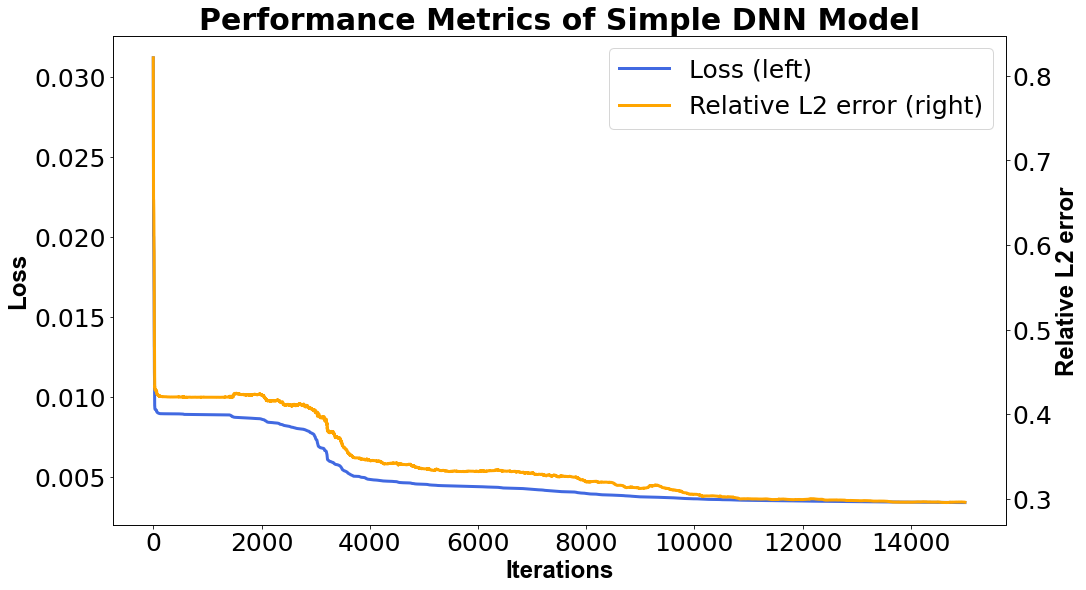

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.10850007161151964
MSE =  0.6039218548767044
RMSE =  0.7771240923280557
L2 relative error = 5.514358272387111
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

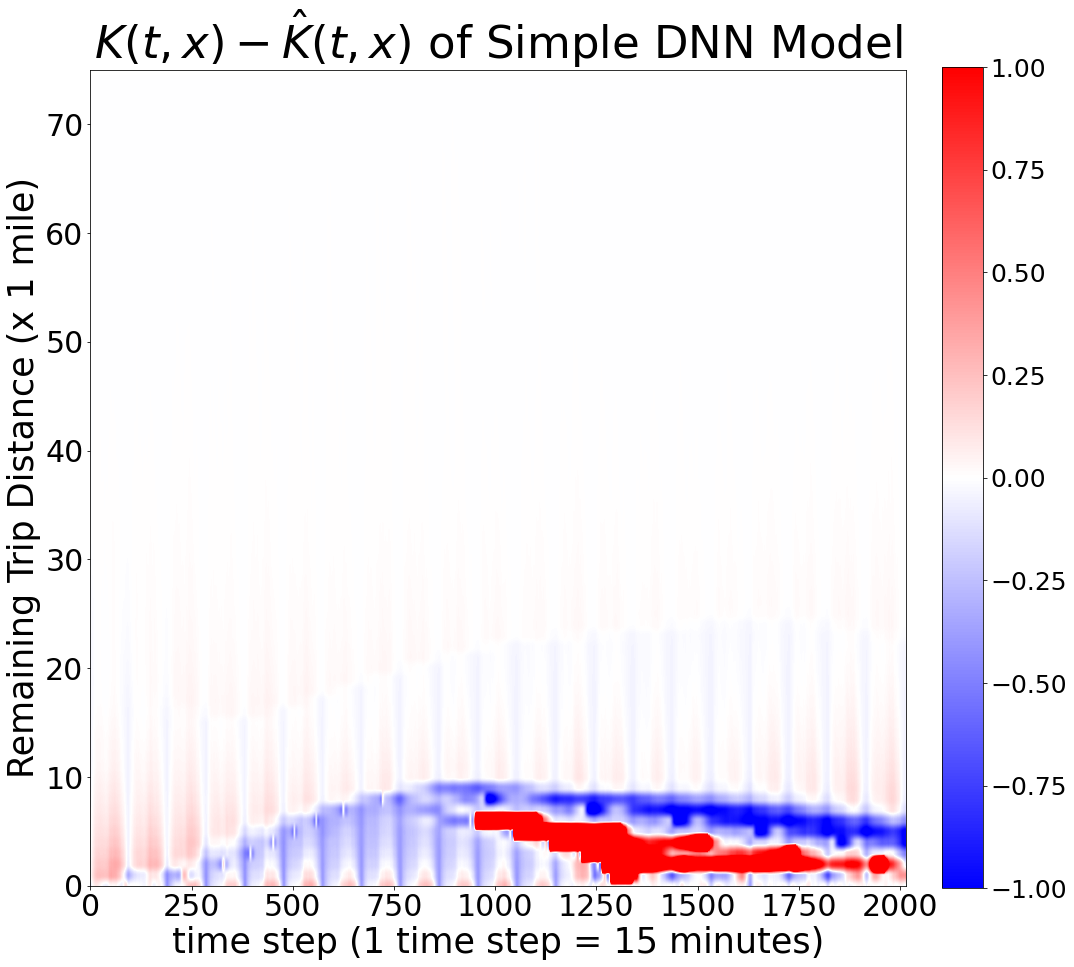

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

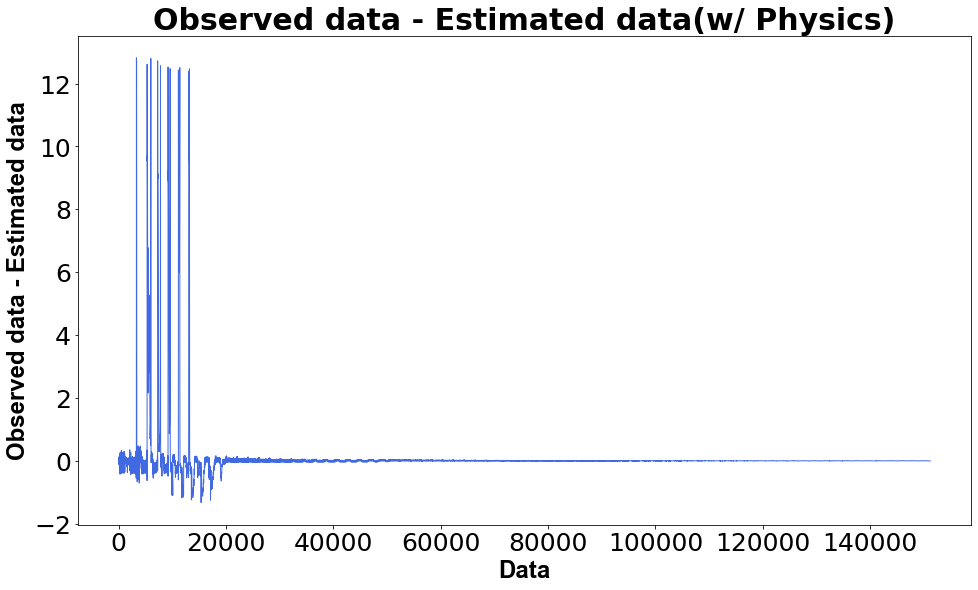

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)